# Submission for Fundamentals of Social Data Science

##### 2020.12.09

##### Candidate number: 1047951

##### Word Count: 3499

# Part 1. Exploring the Relationship Between Rural Areas and COVID-19

## Introduction
The purpose of this essay is to analyze the relationship between COVID-19 spread and death rate, and rural areas. Our world is characterized by heterogeneity in urban development; understanding whether there is a difference in the case and death outcomes between rural and urban regions can help inform present policy decision-making and aid in the formation of pre-emptive policy measures in the future. 

Rural areas are territories with low population density; however, it is not feasible to narrow down the definition since it varies by country (World Bank, 2020). This is elaborated in the limitations section together with its implications on the research.

### Covid-19 spread and rural areas
COVID-19 might spread both faster and slower in rural areas. The spread might be faster in rural areas because of factors such as worse law enforcement (e.g. NRCN, 2015) which enables greater free-riding; inferior sanitary conditions (e.g. Chaudhuri & Roy, 2017), while sanitation has been noted as essential for preventing COVID-19 (WHO, 2020); Slower information dissemination practices (Salim, 2013); Lower adoption and efficiency of contact tracing technology in rural areas (e.g. Pew Research Center, 2019)

COVID-19 might also spread slower due to less inbound traveling and mobility in urban areas that have been associated with increased COVID-19 cases (Badr et al., 2020). Furthermore, the lower density of people in rural makes it less likely to get into close contact with one another, ceteris paribus. Given the ambiguous relationship, I hypothesize that:

>H<sub>1</sub>: There is no observable difference between the number of COVID-19 cases and the percentage of the rural population in a country.

### Covid-19 death and rural areas

In the paper, I operationalize deaths as deaths per the number of cases, as opposed to death per population, to control for the number of cases in my analysis. 

The death rate might be higher in rural areas because there are fewer and inferior medical facilities. There are often fewer doctors per capita in rural areas (OECD, 2015) with more obstacles to overcome for comparative healthcare (Palmer et al., 2019). Furthermore, rural dwellers tend to be older (e.g. DEFRA, 2018), exposing them to greater risk to COVID-19. However, they might have fewer death rates due to better health conditions (Spasojevic et al., 2015). I argue that fewer and inferior medical facilities are the predominant factors that contribute to higher deaths in rural areas.
> H<sub>2</sub>: The COVID-19 death rate increases as a country's relative rural area increases.

A summary of the relationships is provided below.

<img src="./img/relationship.png" alt="COVID-19 and rural areas" width="800"/>

### Methodology

In this analysis, I do not control or link any of the aforementioned factors, but, rather, visually inspect rural areas and COVID-19 deaths and cases to find patterns in the relationship; the theoretical link described can aid in explaining the logical mechanism for their relationship. Daily as opposed to cumulative numbers for cases and deaths to capture the dynamic relationship. Variables are aggregated to different time units where appropriate. 

I adjust the variables to see the relationship per capita and control for the population size. The World Bank did not have data for 30 countries in the initial OXCOVID19 data, thus they were dropped. Furthermore, 63 countries had negative growth of daily COVID-19 cases (calculated as the case difference between two days). Excluding all these countries would be harmful to the scope of the analysis, thus only the countries with a cumulative drop of more than 5% of total cases were removed and other countries were left. Four countries were thus removed from the analysis due to unreliable data.

The key focal point of the exploratory data analysis (EDA) is to explore:

- How the number of deaths and cases differ between countries with different rural populations.
- How the numbers have changed as COVID-19 evolved in different rural populations.
- How the governments reacted differently to COVID-19 measures from different rural areas.

Including governmental measures attempts to explain the difference, if exists, between rural areas and COVID-19 death and spread.

To make the analysis more visually presentable, countries are divided into small (up to 40% rural), medium (up to 40-70% rural), and high (70% or more) categories. Data quality is ensured in different stages of the analysis.

## Analysis

In [1]:
# Import wrangling packages
import os
import math
import pandas as pd
import numpy as np
import psycopg2
import itertools
import warnings
from scipy.stats import pearsonr
from difflib import SequenceMatcher
from datetime import datetime, timedelta

# Import visualization packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style

import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon

### Extracting data

#### Connecting to the database

In [2]:
# Establish connection

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

#### Extracting data on COVID-19

In [3]:
def get_cases(conn):
    """Get the dataframe of the cases and population
    
    Args:
        conn (connection): a connection to the OXCOVID-19 DB
        
    Returns:
        cases_df (dataframe): dataframe containing COVID-19 data
    """

    # Get total number of cases
    sql_command = """
    SELECT  ep.date,
            ep.country,
            ep.confirmed,
            ep.dead, 
            ep.countrycode,
            wb.country AS country_wb,
            wb.value AS population
    FROM epidemiology AS ep
    LEFT JOIN world_bank AS wb
        ON ep.countrycode = wb.countrycode
    WHERE ep.source = 'WRD_WHO'
            AND wb.indicator_name = 'Population, total'
            AND wb.year = 2019 -- Maximum year
    """
    cases_df = pd.read_sql(sql_command, conn)

    # Check data quality
    assert (cases_df['country'] == cases_df['country_wb']).mean() == 1, 'Not all countries are identical. Re-check join key.'
    assert cases_df.isnull().values.any() == False, 'There are missing values'

    
    # Check countries that are not included
    sql_command2 = """
    SELECT DISTINCT country
    FROM epidemiology

    EXCEPT

    SELECT DISTINCT country
    FROM world_bank
        """

    excluded = pd.read_sql(sql_command2, conn)
    print(f"A total of {len(excluded)} entries are excluded from the initial dataset since they do not have data for Population.\n"
          f"These are: {', '.join(excluded['country'])}")
    
    return cases_df


def calculate_capita_metrics(cases_df):
    """Calculate key metrics later used in the analysis
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data
        
    Returns:
        cases_df (dataframe): dataframe with additional metrics
    """
    cases_df['confirmed_per_100K'] = (cases_df['confirmed'] / cases_df['population']) * 100_000
    cases_df['dead_per_100K'] = (cases_df['dead'] / cases_df['population']) * 100_000
    cases_df['dead_per_cases'] = cases_df['dead'] / cases_df['confirmed']
    
    cases_df['date'] = pd.to_datetime(cases_df['date'])
    cases_df['month'] = cases_df['date'].dt.month
    
    return cases_df


def get_daily_growth(cases_df):
    """Calculate daily growth of cases from the number of cumulative cases
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data.
        
    Returns:
        cases_df (dataframe): dataframe with COVID-19 case differences.
    """
    # Get unique country list
    countries = cases_df['country'].unique()
    
    # Sort the df (diff calculations only work if it is sorted by country and year)
    cases_df.sort_values(['country', 'date'], ascending = True, inplace = True)
    
    # Get daily growth (proportional and absolute)
    differences = {'diff_total': 'confirmed',
                   'diff_per_100K': 'confirmed_per_100K'}
    
    for country in countries:
        for col, measure in differences.items():
            cases_df.loc[cases_df['country'] == country, col] =\
            cases_df.loc[cases_df['country'] == country, measure].diff().fillna(0)
        
    return cases_df


def get_newest_df(cases_df, time_lag=5):
    """Get the newest data for the query with available data
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data.
        time_lag (int, optional): number of days to substract from today for extracting data.
        
    Returns:
        df_newest (dataframe): dataframe with newest data.
    """
    
    newest_date = (datetime.today() - timedelta(days=time_lag)).strftime('%Y-%m-%d') 

    df_newest = cases_df[cases_df['date'] == newest_date]
    
    # Check that no data is lost
    assert df_newest['country'].nunique() == len(df_newest), 'Countries are not unique'
    assert df_newest['country'].nunique() == cases_df['country'].nunique(), f'Not all countries have the date {newest_date}'
    
    return df_newest


def daily_growth_check(cases_df, drop_countries=True, drop_threshold=0.05):
    """Check whether the daily growth of COVID-19 cases is below zero. 

    Perform a check on the number of daily COVID-19 cases for each country and excludes
    countries with a high number of negative daily cases. The daily cases should never be
    negative. The methodology for determining whether to drop a country or not is as follows.
    
    1. Extracting the total number of negative growth cases for each country
    2. Comparing the total number of negative growth cases to the overall cases in the country
    3. If the proportion of these is smaller than the threshold, the negative drop is deemed to be
    insigifnicant. Otherwise, the country is removed
    
    Example: Oxlandia had a cumulative number of 40,000 and 39,900 cases on September 1st and 2nd, respectively.
    Oxlandia currently has a total of 100 thousand cummulative cases. Since the drop was 100 cases, it is only 0.1%
    of if its current cases. If the drop is less than the threshold, Oxlandia is not removed.
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data.
        drop_countries (boolean): indicate whether to drop countries or not.
        drop_threshold (float): the threshold beow which countries are dropped.
        
    Returns
        cases_df (dataframe): new dataframe without the countries that have overall drops above the specified threshold.
    """
    
    
    # Check if there are negative cases
    negative_diff = np.sum(cases_df['diff_total'] < 0)
    if negative_diff > 0:
        print(f"\nThere are {negative_diff} cases of negative daily growth in cases from the data\n")
        
        # Get the drops for all the countries
        negative_df = cases_df[cases_df['diff_total'] < 0].copy()
        all_drops = negative_df.groupby('country').diff_total.sum()
        
        if drop_countries:
            # Calculate the countries with a drop above the threshold
            df_newest = get_newest_df(cases_df)
            drop_countries = []
            for country in all_drops.index:
                total_cases = df_newest.loc[df_newest['country'] == country, 'confirmed']
                perc_drop =  - (all_drops[country]/total_cases).values
                if perc_drop > drop_threshold:
                    drop_countries.append(country)

            if len(drop_countries) > 0:
                print("Dropped {} countries from further analysis: {}.\n".format(len(drop_countries), ', '.join(drop_countries)))
                cases_df = cases_df[~cases_df['country'].isin(drop_countries)]            

        return cases_df

cases_df = get_cases(conn)
cases_df = calculate_capita_metrics(cases_df)
cases_df = get_daily_growth(cases_df) 
cases_df = daily_growth_check(cases_df, drop_countries = True)

A total of 30 entries are excluded from the initial dataset since they do not have data for Population.
These are: Mayotte, Other continent, Saint Helena, Oceania, Pitcairn Islands, Martinique, Reunion, Wallis and Futuna, Guernsey, Montserrat, Cook Islands, Kosovo, Asia, French Guiana, Bonaire, Sint Eustatius and Saba, Tokelau, Saint-Barthélemy, America, Saint Pierre and Miquelon, Falkland Islands, Taiwan, Niue, Anguilla, World, Guadeloupe, Africa, Vatican City, Western Sahara, Europe, Jersey

There are 64 cases of negative daily growth in cases from the data

Dropped 4 countries from further analysis: Benin, Ecuador, Puerto Rico, São Tomé and Príncipe.



#### Extracting data on Rural Areas

In [4]:
# Getting rural data for the year 2019

def get_rural_data(conn=conn, cases_df=cases_df):
    """Get rural data from the database and return a dataframe
    
    Args:
        conn (connection, optional): Connection to the OXCOVID-19 db.
        cases_df (dataframe, optional): dataframe containing COVID-19 data.
        
    Returns:
        df (dataframe): dataframe that contains rural information
    """

    # Get SQL command
    sql_command = """
    SELECT country, value, indicator_name
    FROM world_bank
    WHERE 
        -- Two indicators are available for 2019, but density is available only for 2018.

        ((indicator_name IN ('Rural population (% of total population)', 'GDP per capita, PPP (current international $)')
            AND year = 2019) 
        OR (indicator_name = 'Population density (people per sq. km of land area)'
        AND year = 2018))

        AND source = 'World Bank'
        AND countrycode IS NOT NULL

    """
  
    # Read dataframe
    rural_df = pd.read_sql(sql_command, conn)

    # Check countries that are not included
    diff_list = np.setdiff1d(cases_df['country'].unique(), rural_df['country'].unique())
    print(f"Countries excluded because they do not have data on indicators from the World Bank: {', '.join(diff_list)}")
    
    # Merge dataframes
    rural_df = pd.pivot_table(rural_df, index = 'country', columns = 'indicator_name', values = 'value')
    rural_df.columns = ['gdp', 'pop_density', 'rural_pop_perc']

    df = pd.merge(cases_df, 
             rural_df,
             how = 'inner', 
             left_on = 'country',
             right_on = 'country', 
             validate = 'many_to_one')
    
    # Get category
    df['rural_category'] = df['rural_pop_perc'].map(lambda x: 'High' if x >= 70 else 'Low' if x <= 40 else 'Medium')
   
    return df


def get_logs(df, vars_to_log = ['dead_per_100K',
                                'dead_per_cases',
                                'confirmed_per_100K',
                                'gdp']):
    """Calculate the logarithms of selected variables that are later used in the analysis.
    Epsilon is used to add a small number to avoid infinity (log(0) = inf)
    
    Args:
        df (dataframe): dataframe with variables.
        vars_to_log (list, optional): variables to convert to a logarithmic scale.
        
    Returns:
        df (dataframe): dataframe enhanced with the transformed variables.

    """
    epsilon = np.finfo(np.float64).eps

    for var in vars_to_log:
        df[var + '_log'] = np.log(df[var] + epsilon)
    
    return df


df = get_rural_data()
df = get_logs(df)

Countries excluded because they do not have data on indicators from the World Bank: Saint-Martin


### EDA for rural areas

#### Rural Distribution (Figure 2)

In [5]:
def annotate_plot(annotation_text, x1=.01, x2=.05, top=.8, bottom=.2, fontsize=12):
    """Annotate a given with the specific parameters
    
    Args:
        annotation_text (str): text to annotate a plot with
        x1, x2 (float): the point (x1,x2) to annotate
        top, bottom (float): margin reduction parameter
        fontsize (float): fontsize of the annotation text

    Returns:
        None
    """
    
    plt.annotate(annotation_text,
                xy=(x1, x2), 
                xycoords='figure fraction',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=fontsize, 
                color='#555555')

    plt.subplots_adjust(top=top)
    plt.subplots_adjust(bottom=bottom)
    

def get_geodf(df_newest):
    """Merge a dataframe with data from geopandas to construct a geopandas dataframe
    
    Args:
        df_newest (dataframe): dataframe containing the most recent date
    
    Returns:
        world_merged (dataframe): dataframe enhanced with geospatial data
    """
    # Import world and merge
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_merged = world.merge(df_newest, left_on='iso_a3', right_on='countrycode')

    # Check merge
    not_merged = set(df_newest['country']) - set(world_merged['country'])
    if len(not_merged) > 0:
        print("A total of {} countries or areas were not included: {}".format(len(not_merged), ', '.join(not_merged)))

    return world_merged


def plot_areas(world_merged, no_edges = True):
    """Plot the world in rural areas
    
    Args:
        world_merged (dataframe): dataframe containing geospatial data
        
    Returns:
        None
    """
    
    fig, ax = plt.subplots(1,1, figsize = (20,10))
    
    world_merged.plot(column='rural_pop_perc',
                      ax = ax, 
                      legend = True,
                      legend_kwds = {'label': 'Rural population (%)',
                                     'orientation': 'vertical'},
                      edgecolor = 'none',
                      cmap = 'Blues')
    if no_edges:
        ax.axis('off')
        
    ax.set_title('Figure 2. Rural population by country (%) in 2019', fontsize = 17)
    
    # create an annotation
    annotation_text = """Note: Rural population refers to people living in rural areas as defined by national statistical offices."""
    annotate_plot(annotation_text, x1=.05, x2=.08, fontsize=12)
    
df_newest = get_newest_df(df)
world_merged = get_geodf(df_newest)

A total of 42 countries or areas were not included: Andorra, Mauritius, Saint Vincent and the Grenadines, Saint Lucia, French Polynesia, Monaco, Dominica, Isle of Man, Norway, Comoros, France, Seychelles, Virgin Islands, U.S., Bermuda, Marshall Islands, Maldives, Malta, Faroe Islands, Saint Kitts and Nevis, British Virgin Islands, Kiribati, Micronesia, San Marino, Bahrain, Northern Mariana Islands, Cayman Islands, Tuvalu, American Samoa, Aruba, Singapore, Guam, Samoa, Palau, Barbados, Gibraltar, Cape Verde, Liechtenstein, Turks and Caicos Islands, Tonga, Grenada, Antigua and Barbuda, Nauru


#### Correlation Matrix (Figure 3)

In [6]:
def correlation_matrix(df_newest, plot_vars = ['confirmed_per_100K', 
                                               'dead_per_100K',
                                               'dead_per_cases',
                                               'gdp', 
                                               'rural_pop_perc']):
    """Plot a correlation matrix between the variables provided.
    
    Args:
        df_newest (dataframe): dataframe containing the most recent date
        plot_vars (list): list of variables to plot
        
    Returns:
        None
    """
   
    # Get correlation matrix
    corr_df = df_newest[plot_vars].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.set_theme(style="white")

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(7, 6))

    # Generate a custom diverging colormap
    cmap = sns.dark_palette("#69d", as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
    
    ax.set_title("Figure 3. Correlation matrix of selected variables ", fontsize = 17)
    
    plt.plot()

#### Temporal Overview (Figure 4)

In [7]:
def plot_rural_over_time(df, from_date='2020-01-01', to_date='2020-11-20'):
    """Plot rural areas over time
    
    Args:
        df (dataframe): dataframe containing information on the data to plot
        from_date (string): date to plot from
        to_date (string): date to plot until
        
    Returns:
        None 
    """
    
    # Create fig, ax objects
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    fig.suptitle('Figure 4. Covid-19 and Rural Areas: Cumulative Cases and Growth')
    
    date_format = mdates.DateFormatter('%b')

    # Get plots
    df_plot = df[df['date'].between(from_date, to_date)]
    sns.lineplot(data=df_plot, x = 'date', y = 'confirmed_per_100K', hue = 'rural_category', ax = axs[0])
    sns.lineplot(data=df_plot, x = 'date', y = 'diff_per_100K', hue = 'rural_category', ax = axs[1])

    # Set parameters
    axs[0].set_title('Cumulative cases in different rural categories')
    axs[0].set_ylabel('Confirmed COVID-19 cases per 100 thousand people')
    axs[0].set_xlabel("Date, 2020")
    axs[0].xaxis.set_major_formatter(date_format)
    axs[0].legend(loc='upper left')
    
    axs[1].set_title('Daily changes in cases in different rural categories')
    axs[1].set_ylabel('Daily COVID-19 case change per 100 thousand people')
    axs[1].set_xlabel("Date, 2020")
    axs[1].xaxis.set_major_formatter(date_format)
    axs[1].legend(loc='upper left')

    fig.tight_layout()

#### Split by Continent (Figure 5,6)

In [8]:
def distribution_plotter(df, variable, fig_no, top=0.9):
    """Plot COVID-19 cases by rural category and continent
    
    Args:
        df (dataframe): dataframe containing plot information
        variable (string): variable name to plot in the distribution
        fig_no (int): Number for the figure title
        top (float): Adjustment of top plot part
    
    Returns:
        None
    """
    
    # Get text of the variable
    if 'dead' in variable.lower(): var_name = 'deaths'
    else: var_name = 'cases'

    # Get plots
    g = sns.FacetGrid(df, col = 'continent', col_wrap = 3, hue = 'rural_category', hue_order = ['Low', 'Medium', 'High'],
                      height = 3.5, aspect = 1.2, legend_out = True, sharey = False)
    g = g.map(sns.kdeplot, variable, fill = True, legend = True, cut = 4, clip = (0,None), bw_adjust = .8)
    g.add_legend()

    # Add title and adjust height
    g.fig.suptitle(f'Figure {fig_no}. COVID-19 {var_name} in different continents by rural category') 
    plt.subplots_adjust(top=top)

        
def plot_covid_distribution(df, variable, fig_no, no_warning=True, remove_zeros=True):
    """Plot the distribution of confirmed COVID-19 deaths or cases by rural category and continent
    
    Args:
        df (dataframe): dataframe containing plot information
        variable (string): variable name to plot in the distribution
        fig_no (int): Number for the figure title
        no_warnings (boolean, optional): supress warnings
        remove_zeros (boolean, optional): remove zeros from the distribution
  
    Returns:
        None
    
    """
    if remove_zeros:
        df = df[df[variable] != 0]

    if no_warning:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
            distribution_plotter(df, variable, fig_no=fig_no)
            
            # Add annotation
            annotation_text = f"""Note: If a category does not have a distribution, that means that it has either one or zero obsrvations and a distribution cannot be formed. \nCountries with a value of zero are removed."""
            annotate_plot(annotation_text, top = 0.9, bottom = 0.2)

    else:
        distribution_plotter(df, variable)


### EDA for government intervention

#### Extracting governmental data

In [9]:
def get_gov_data(threshold=0.8):
    """Extract governmental data from the postgres database and checks for high similarities between entries
    
    Args:
        threshold (float): the threshold for deciding whether strings are similar
        
    Returns:
        gov_df (dataframe): dataframe containing government response information
    """

    # Extract the data
    sql_command = """
    SELECT date, country,c6_Stay_at_home_requirements,  c6_Flag
    FROM government_response
    WHERE source = 'GOVTRACK'
    """
    gov_df = pd.read_sql(sql_command, conn)
    gov_df['date'] = pd.to_datetime(gov_df['date'])
    
    # Inspect countries for similarities (to try to find duplicate entries)
    countries_lower = [c.lower() for c in gov_df['country'].unique()]
    
    print("Countries with similar strings: ")
    for c1, c2 in itertools.combinations(countries_lower, 2):
        if SequenceMatcher(None, c1, c2).ratio() > threshold:
            print(f"Country 1: {c1} Country 2: {c2}")
            
    return gov_df


def get_stay_at_home_metrics(gov_df):
    """Add additional stay-at-home metrics to the dataframe

    The function finds the first time a government imposed stay at home requirements
    on a national scale that are at least 2 or 3 in strength, as measured by the
    C6 index on the OXCOVID-19 database. Local restrictions are not taken into account.
    
    The function calculates:
    - the number of days before and after the introduced requirements for each day and country
    - the number of weeks before and after the introduced requirements for each day and country
    
    The weeks are calculated on a daily basis as opposed to taking calendar weeks. For example,
    the first 7 days after the introduction of the requirements are considered week 1, regardless
    of the day of the week. Note that this calculation does not take into account if a government
    uplifted its requirements.
    
    Args:
        gov_df (dataframe): Dataframe containing government response information
        
    Returns:
        gov_df (dataframe): New dataframe that includes additional columns on government response
    """
    
    # Get countries with stay at home requirements on a national level
    countries_with_req = gov_df.loc[(gov_df['c6_stay_at_home_requirements'].isin([2,3])) 
               & (gov_df['c6_flag'] == 1), 'country'].unique()
    gov_df = gov_df[gov_df['country'].isin(countries_with_req)].copy()
    gov_df.sort_values(['country', 'date'], inplace = True)
    gov_df.index = pd.RangeIndex(len(gov_df))
    
    # Loop over all the countries
    for country in countries_with_req:
        
        # Filter country specific values
        gov_filter = gov_df.country == country        
        first_country_filter = gov_df.loc[gov_filter].index.min()
        
        # Get the id of stay at home requirements
        home_id_any_level = gov_df.loc[gov_filter, 'c6_stay_at_home_requirements'].isin([2,3]).idxmax()
        c5_flag = (gov_df.loc[gov_filter, 'c6_flag'] == 1).idxmax()
        home_id = max(c5_flag, home_id_any_level)

        # Get days before and after filters
        days_before_filter = gov_df.index < home_id
        days_after_filter = gov_df.index >= home_id

        # Assign the number of days before and after for each country
        gov_df.loc[gov_filter & days_before_filter, 'days_after'] = range(first_country_filter-home_id, 0, 1)
        gov_df.loc[gov_filter & days_after_filter, 'days_after'] = range(0, np.sum(gov_filter & days_after_filter))
        gov_df.loc[gov_filter, 'weeks_after'] = gov_df.loc[gov_filter, 'days_after'].map(
            lambda day: math.ceil(day/7) if day > 0 else math.floor(day/7))
        
    
    # Merge in rural category data
    gov_df = pd.merge(gov_df, df[['date', 'country', 'rural_category', 'rural_pop_perc', 'diff_per_100K']], 
                      on = ['date', 'country'], validate = 'one_to_one')
    
    # Check data quality
    maxdays = (gov_df['date'].max() - gov_df['date'].min()).days + 7 # adding an additional week b/c of rounding
    maxweeks = math.ceil(maxdays/7)
    
    assert gov_df['weeks_after'].max() <= maxweeks, 'At least one week_after value is too large for the given date range'
    assert gov_df['days_after'].max() <= maxdays, 'At least one days_after value is too large for the given date range'
    assert -gov_df['days_after'].min() <= maxdays, 'At least one days_after value is too small for the given date range'
    assert -gov_df['weeks_after'].max() <= maxweeks, 'At least one week_after value is too small for the given date range'
    
    return gov_df


gov_df = get_gov_data()

# Excluding "Viet nam" since it is entered two times
gov_df = gov_df[gov_df['country'] != 'Viet Nam']

# Extracting additional metrics for plotting
gov_df = get_stay_at_home_metrics(gov_df)

Countries with similar strings: 
Country 1: vietnam Country 2: viet nam
Country 1: zambia Country 2: gambia
Country 1: australia Country 2: austria
Country 1: ireland Country 2: iceland
Country 1: nigeria Country 2: niger


#### Plotting government intervention timelines (Figure 7)

In [11]:
def gov_intervention_plot(gov_df):
    """Plot the dates of when the government intervened for the first time in different rural regions.
    
    Args:
        gov_df (dataframe): Dataframe containing government response information
        
    Returns:
        None
    """
    
    # Get days when the government intervened with the policy
    df_plot = gov_df.loc[gov_df['days_after'] == 0, ['date', 'rural_category']]
    
    # Get date format
    date_format = mdates.DateFormatter('%b')
    
    # Create the plot
    fig, axs = plt.subplots(1,3, figsize=(15,4), sharex = True)
    fig.suptitle('Figure 7. Covid-19 and the first time of national stay at home requirements by rural area type')

    # Dictionary for looping
    rural_dict = {'Low': 0,
     'Medium': 1,
     'High': 2}

    # Configure each graph in a loop
    for category, i in rural_dict.items():
        sns.histplot(df_plot[df_plot['rural_category'] == category], x = 'date', ax = axs[i], bins = 10)
        axs[i].set_title(f"Rural category: {category}")
        axs[i].xaxis.set_major_formatter(date_format)
        axs[i].set_ylabel("Number of countries")
        if i != 0: axs[i].set_ylabel("")
   
    
    # Add annotation
    annotation_text = """Note: The y-axes are different for each plot to showcase the relative distributions within each group"""
    annotate_plot(annotation_text, top = 0.8, bottom = 0.2,  x1=.06, x2=.05)


#### Plotting weekly cases by rural area and time (Figure 8)

In [12]:
def get_categories(v):
    """Divide a number into distinct categories of 10. For instance, '5' becomes '0-10' and 23 becomes '20-30'
    
    Args: 
        v (float): a number
    
    Returns:
        range_value (string): a range between the two numbers
        
    """
    
    v1 = str(int(v/10)*10)
    v2 = str(int(v1) + 10)
    range_value = v1 + '-' + v2
    return range_value


def get_agg_rural_data(gov_df):
    """Get aggregated rural data based on the dataframe and prepares it for the right
    format for plotting
    
    Args:
        gov_df (dataframe): Dataframe containing government response information
 
    Returns:
        df_at_home_agg (dataframe): Aggregated information of the previous dataframe
    """
    
    # Create rural categories
    gov_df['rural_pop_perc_categ'] = gov_df['rural_pop_perc'].map(get_categories)
    
    # Create the values to be plotted
    df_at_home_agg = pd.pivot_table(gov_df[gov_df['weeks_after'].between(-8, 15)],
               index = ['rural_pop_perc_categ'],
               columns = 'weeks_after',
              values = 'diff_per_100K',
              aggfunc = 'mean').drop(0, axis = 1)
    
    # Convert weeks to intigers
    df_at_home_agg.columns = [int(x) for x in df_at_home_agg.columns]
    
    # Reverse order to ensure it is from low to high
    df_at_home_agg = df_at_home_agg.loc[df_at_home_agg.index[::-1]]
    
    return df_at_home_agg

df_at_home_agg = get_agg_rural_data(gov_df)

In [13]:
def plot_cases(df_at_home_agg):
    """Plot a heatmap of number of new weekly cases per 100K by rural category and week after
    the introduction of the nation-wide stay at home requirements.
    
    Args:
        df_at_home_agg (dataframe): Aggregated information on information to plot
        
    Returns:
        None
    """

    # Set palette
    cmap = sns.dark_palette("#69d", reverse = True, as_cmap=True)

    # Create subplot
    fig, ax = plt.subplots(1,1, figsize = (15,5))
    fig.suptitle('Figure 8. Number of new weekly cases per 100K people after stay-at-home requirement introduction', fontsize=15)

    # Create heatmap and params
    sns.heatmap(df_at_home_agg, vmin = 0, vmax = 6, cmap = cmap, linecolor = 'white', linewidth = 0.01, ax = ax)
    ax.vlines([8], *ax.get_xlim(), linestyle = 'solid', colors = 'black', label = 'test', lw = 3)
    plt.text(6,0,'Requirements introduced\n', fontdict = {'weight': 100, 'size': 12})
    ax.set_xlabel('Weeks after the introduction of nation-wide stay-at-home requirements')
    ax.set_ylabel('Rural population in the country, %')
    plt.yticks(rotation=0);
    

## Results

In this part, I present the results of the research by (a) overviewing the distribution of rural areas, (b) observing the relationship between rural areas and COVID-19 cases, and (c) offering possible explanations.

First, we can observe that the largest parts of the rural population are located in the Global South, as presented in Figure 2.

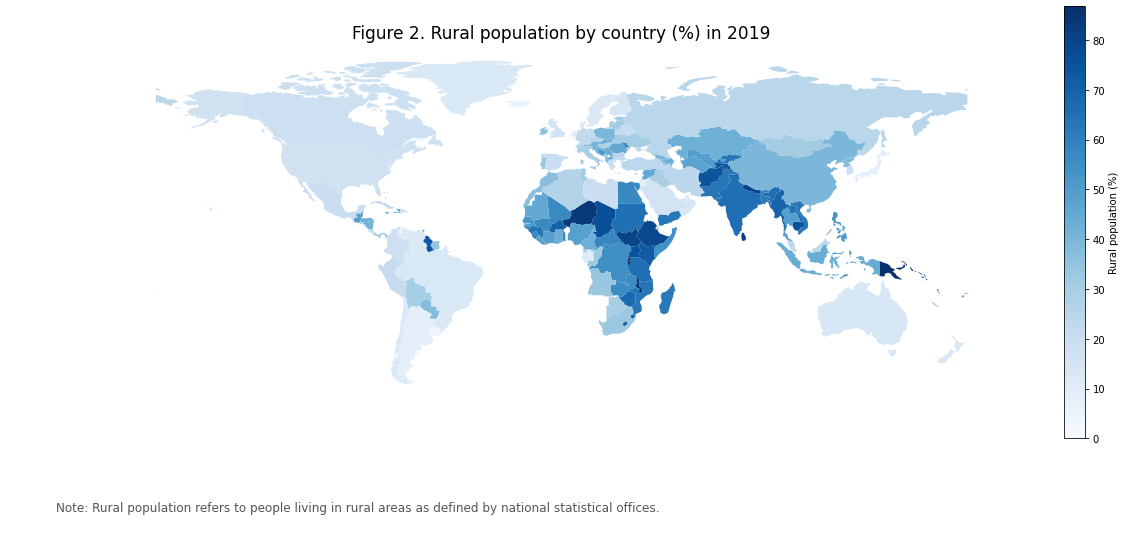

In [14]:
plot_areas(world_merged)

This can have important implications for the research, as looking at rural areas might become a proxy for economic development. In particular, the Pearson's correlation coefficient between economic development (defined by GDP per capita, adjusted for PPP) and rural population is -0.64.

The correlation between COVID-19 deaths, cases, rural population, as well as GDP and population density is provided in Figure 3.

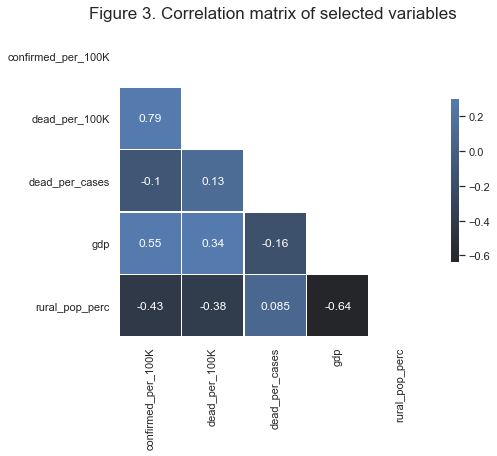

In [15]:
correlation_matrix(df_newest)

Rural population is rather strongly correlated with confirmed cases per 100 thousand people (r=-0.43) and deaths (r=-0.38). This means that as a country has a more rural population, it should have fewer confirmed cases and deaths per 100 thousand people. Note that there is little correlation with dead people per cases which would control for the number of cases in the population. This is likely because confirmed and dead cases per 100 thousand people are themselves correlated at r=0.78, thus deaths per capita do not properly control for cases.

Figure 4 presents the cumulative number of cases for different rural categories on the left, as well as their daily changes on the right. This enables us to view the difference between rural regions and COVID-19 in time. 


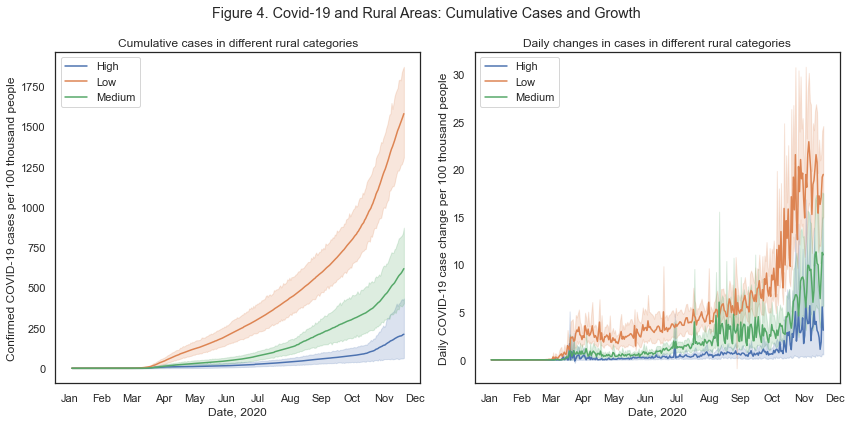

In [16]:
plot_rural_over_time(df)

The number of COVID-19 cases has been the highest for countries with fewer rural areas adjusted for the population during all months. Note that the daily changes were consistently higher for countries with a lower population too.

It is important to look at different contexts, however. It might be the case that this is not a result of rural areas per se, but, rather, economic development. One way to control for this is to separate the analysis by continent and observe whether countries with fewer rural categories still have more cases within each continent. Figure 5 presents the distribution of COVID-19 cases for each category by continent.

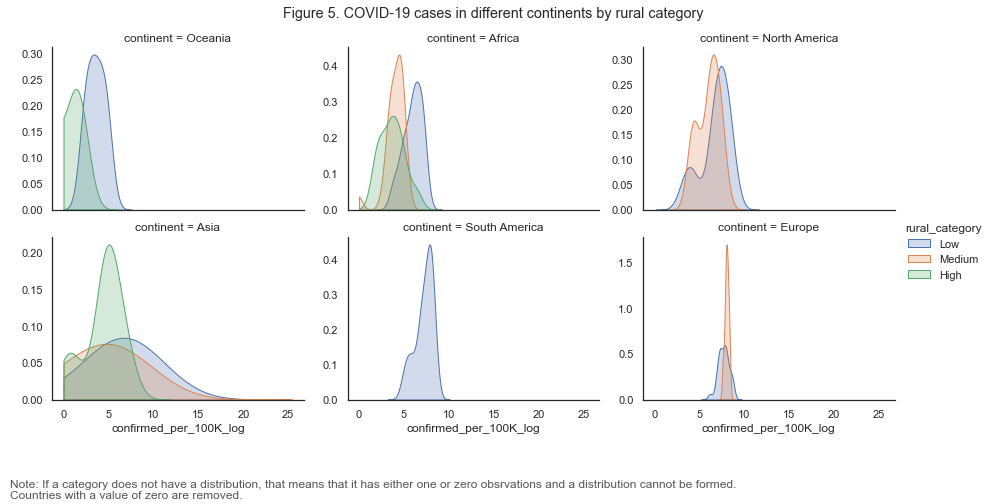

In [17]:
plot_covid_distribution(world_merged, 'confirmed_per_100K_log', 5)

It seems that countries in Africa, North America, and Asia have slightly more cases if they have lower rural categories, yet with a substantial degree of overlap. There is insufficient data for South America, while in Europe there seems to be no visual difference between the two.  Figure 6 depicts similar distributions for the number of deaths.

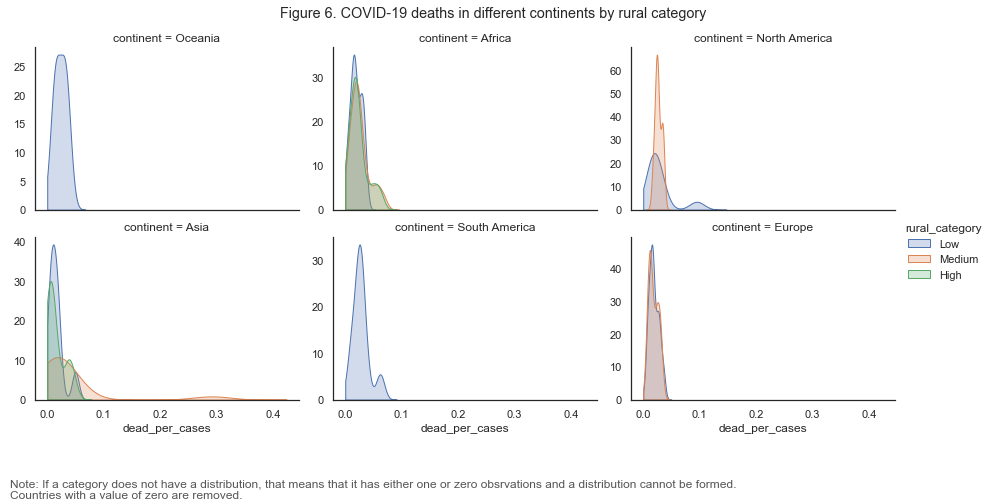

In [18]:
plot_covid_distribution(world_merged, 'dead_per_cases', 6)

There seems to be no difference in the peaks of the distributions in all of the continents with the possible exception of Asia, suggesting that there is no clearly observable relationship between rural categories and COVID-19 cases.

From the data that has been observed so far, I reject my first hypothesis stating that there is no relationship between COVID-19 cases and rural populations, as the visualizations do suggest a difference exists. Likewise, I reject my second hypothesis, as there seems to be no observable difference in the number of deaths, operationalized as deaths per cases.

One reason why countries with smaller rural populations have higher cases could be because a result of effective government intervention. To understand whether government intervention was the key factor for different COVID-19 cases, I look into national stay-at-home policy enforcement. The figure below showcases when the governments intervened with stay-at-home requirements by rural area type.

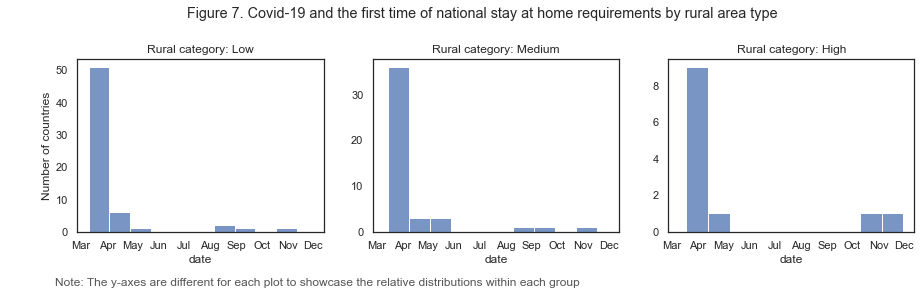

In [19]:
gov_intervention_plot(gov_df)

Visually, it seems that most of the interventions happened between March and April, regardless of the rural category. However, simply looking at the time of the intervention is insufficient, since the case count might have been drastically different at the same point in time. Hence, Figure 8 looks at the relative distribution of cases for COVID-19 in terms of weeks before and after the government intervention, divided by rural category.

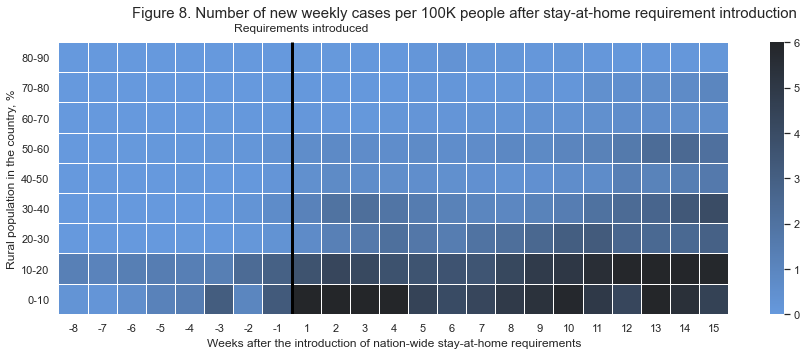

In [20]:
plot_cases(df_at_home_agg)

Each box is an average of the number of new weekly cases per 100 thousand people in a given rural population bin, relative to when nation-wide stay-at-home requirements were introduced.

A clear pattern emerges that countries with lower populations had more cases both before the introduction of the requirements, but especially afterward. The number of cases after the introduction of the requirements increased the most for countries with low rural populations and persisted for a longer time. However, this data does not support the hypothesis that effective government intervention was the reason for fewer cases in rural areas.

Overall, more analysis is required to confirm the existence of the hypothesized relationships.

# Part 2. Fair and balanced? A comparison of the sentiments of two major media outlets in the context of the COVID-19 pandemic

## Introduction

There is a systemic divide between Republicans and Democrats with regards to their preferred news outlet. Republicans trust Fox News and distrust CNN the most, with the opposite holding for Democrats (Jurkowitz et al., 2020). This phenomenon has important implications for information dissemination to the general public. For example, an increase in Fox News viewership is associated with non-compliance with social distancing during the pandemic (Simonov et al., 2020) or consumption of fewer virus-protective products, such as masks or hand sanitizers (Ash et al., 2020).

In this essay, I build upon this research by analyzing the sentiments of coronavirus-related articles from CNN and Fox News. The existing research suggests that the effect of Fox News on viewer behavior is partially attributed to program-specific content that minimized the COVID-19 threat (ibid.). Therefore, I hypothesize that:

> H<sub>1</sub>: Fox News coronavirus-related article sentiment is significantly more positive than CNN article sentiment.

During the pandemic, US elections also took place. Mass media is an important factor that can shape election results (Graber & Dunaway, 2017). For instance, Fox News has previously shaped elections in favor of the Republican party (Martin & Yurukoglu, 2017). Given that the viewership of Fox News and CNN are Republicans and Democrats, respectively, I hypothesize that :

> H<sub>2</sub>: Fox News articles mentioning the US president show greater positive sentiment than those which do not.

> H<sub>3</sub>: CNN articles mentioning the US president show greater negative sentiment than those which do not.

## Methodology

To achieve the goal of the study, all the media articles that have the word 'coronavirus' from CNN and FOX News starting from 2020-05-11 to 2020-11-20 are scraped. A rule-based sentiment analysis feature extractor VADER (Hutto & Gilbert, 2014) is used to analyze the data. The data is then used to:
- compare the article sentiment differences between CNN and Fox News;
- analyze the evolution of the sentiments over time;
- compare the sentiments of articles that mention the president with those that do not.

Certain repetitive phrases are manually inspected and removed from FOX News and CNN that do not add any organic content, such as *‘EXCLUSIVE LIVE UPDATES’*. 

Lastly, I extract TF-IDF scores for all the articles and find similar articles using cosine similarity. A network is created in which each node is an article and each edge represents that two articles are related in content **and** sentiment. Articles are considered to be similar if their cosine similarity is above 0.4 and the difference between VADER sentiments is less than 0.2. This allows us to inspect whether similar articles from the same news outlet tend to cluster together or not and whether there are any visual differences in the sentiments portrayed by CNN and Fox News.


## Data Extraction

In [ ]:
# Web and time
from bs4 import BeautifulSoup
import requests
import json
from pprint import pprint
import re
import random
import time
from datetime import datetime, timedelta, date

# Numerical
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind, levene
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

# Visual
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg') # Setting SVG

%matplotlib inline

# NLP
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sop-word packages
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopWords = set(stopwords.words('english'))


# Other
import os
from tqdm import tqdm
import multiprocessing
import concurrent.futures
import networkx as nx

### Scraper Class

In [2]:
# Scraper class
class Scraper:
    """A general scraper class to be used for FOX and CNN Scrapers.
    
    Attributes:
        headers (dict): information on the headers for scraping
        sess (session): session object
        
    Methods:
        get_session: returns a session object
        sleep: sleeps for some time and then executes
    """
    def __init__(self):
        
        # Get headers
        with open("headers.json", "r") as file:
            headers = json.load(file)
        
        # Create a Session object
        self.sess = requests.Session()
        self.sess.headers.update(headers)

    def get_session(self):
        """Return the session"""
        return self.sess
    
    def sleep(func):
        """ Sleep during scraping"""
        def wrapper(*args, **kwargs):
            """A wrapper function that sleeps and then executes"""
            time.sleep(random.uniform(0.5, 1.5))
            return func(*args, **kwargs)
        return wrapper
    
def Non200StatusCodeException(Exception):
    pass
    

### CNN Scraper Class

In [3]:
class CNNScraper(Scraper):
    """A CNN Scraper class for scraping websites from CNN.
    
    The CNN API does not have a convenient filter for dates, thus scraping
    starting from the newest day to the oldest date was used. After an API call,
    CNN returns the article information in JSON format.
    
    Attributes:
        sess (session): session object
        ARTICLES_PER_QUEST (INT): Number of articles during each API request
        articles, urls (list): lists to store articles and URLs
        
    Methods:
        call_api: Call CNN api and returns results
        _save_articles: dump articles to a JSON file
        scrape: scrape articles given a query
    """
    
    def __init__(self):
        """Instantiates the CNN Scraper"""
        super().__init__()
        self.sess = super().get_session()
                
        # Define constants
        self.ARTICLES_PER_REQUEST = 10
        
        self.articles = []
        self.urls = []
        

    @Scraper.sleep
    def call_api(self, pagenum, query):
        """Call CNN API and return results"""

        resp = self.sess.get(
            "https://search.api.cnn.io/content",
            params = {
                "size": self.ARTICLES_PER_REQUEST,
                "q": query,
                "page": pagenum,
                "from": (pagenum-1) * self.ARTICLES_PER_REQUEST,
                "type": "article",
                "sort": "newest"
            }
        )
        
        if resp.status_code != 200:
            """Raise an error if unsuccessful call"""
            raise Non200StatusCodeException("Status Code: " + str(resp.status_code))
        
        return resp.json()["result"]
    
    
    def _save_articles(self, query):
        """Dump the articles to JSON"""
        with open(f"cnn_{query}.json", "w") as file:
            json.dump(self.articles, file)
            

    def scrape(self, query):
        """Main scrape function"""
        # Re-initialize articles and urls lists
        self.articles = []
        self.urls = []

        pagenum = 1
        while True:
            data = self.call_api(pagenum, query)

            # Filter new (unique) articles
            data = [article for article in data if article["url"] not in self.urls]
            if len(data) == 0:
                break
                
            # Printout for logging
            # print(f"Page: {pagenum}, Date of last article: {data[-1]['firstPublishDate']}, New articles: {len(data)}")

            for article in data:
                self.urls.append(article["url"])
                self.articles.append((
                    article["url"],
                    article["headline"],
                    article["firstPublishDate"],
                    article["body"]
                ))

            self._save_articles(query)

            pagenum += 1



In [ ]:
# Scrape articles with the keyword 'coronavirus'

cnn_scraper = CNNScraper()
cnn_scraper.scrape("coronavirus")

### Fox News Scraper

In [4]:
def daterange(date1, date2):
    """Generator that gets two dates and yields a date,
    every time incrementing the day by one
    
    Args:
        date1, date2 (datetime): first and last day for date range
        
    Yields:
        Date incremented by an additional change in time
    """
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        

def get_daterange(start_dt, end_dt):
    """Get a list of dates to iterate over. Used later for 
    querying specific FOX news dates.
    
    Args:
        start_dt, end_dt (datetime): start and end dates for date range
        
    Return:
        dates (list): a list of tuples containing two nearby dates
    """
    
    dates = []
    for i, dt in enumerate(daterange(start_dt, end_dt)):
        d1 = int(dt.strftime('%Y%m%d'))
        d2 = int((dt + timedelta(days=1)).strftime('%Y%m%d'))
        dates.append((d1, d2))
        
    return dates

In [5]:
class FoxScraper(Scraper):   
    """A Fox Scraper Class for scraping articles from Fox News.
    
    The FOX News API has several layers of complexity. Initial calls
    only give URLs of websites. The content has to be scraped after the URLs
    have already been collected. 
    
    Attributes:
        sess (session): session object
        ARTICLES_PER_QUEST (INT): Number of articles during each API request
        articles, urls (list): lists to store articles and URLs
        
    Methods:
        call_api: Call CNN api and returns results
        get_article: gets the article
        scrape_urls: scrape provided URLs, up to 10 pages per date
        _save_articles: dump articles to a JSON file
        get_article_data: extract url, title, date, body from an article
        scrape: loop over the dates with a given query, scrape and save results
        get_articles: return articles
        get_urls: return URLs
        
    """
    def __init__(self):
        """Instantiate FOX News scraper"""
        super().__init__()
        self.sess = super().get_session()
        
        self.urls = []
        self.articles = []
        
        self.ARTICLES_PER_REQUEST = 10
        
    @Scraper.sleep
    def call_api(self, query, date, page):
        """Call an API and try to retrieve data"""
        max_retries = 3
        retries = 1
        
        data = None
        
        while retries < 3 and data is None:
            resp = self.sess.get(
                "https://api.foxnews.com/search/web",
                params={
                    "q": f"{query} -filetype:amp -filetype:xml more:pagemap:metatags-prism.section more:pagemap:metatags-pagetype:article more:pagemap:metatags-dc.type:Text.Article",
                    "siteSearch": "foxnews.com",
                    "siteSearchFilter": "i",
                    "start": page * 10 + 1,
                    "sort": f"date:r:{date}:{date}",
                    "callback": "__jp" + str(page + 1)
                }
            )

            if resp.status_code != 200:
                raise Non200StatusCodeException("Status Code: " + str(resp.status_code))

            elif "The service is currently unavailable." in resp.text:
                if retries < max_retries:
                    print(f"503 Status Code. Retrying ({retries})")
                    retries += 1
                    continue
                return None
            
            data = resp.text
        
        return data
    
    
    @Scraper.sleep
    def get_article(self, url):
        """Gets the article"""
        
        try:
            
            if 'hollistercanada' in url:
                print(f"{url} is not retrieved")
                return None
            else: resp = self.sess.get(url)


            if resp.status_code != 200:
                raise Exception(f"Non-200 Status Code: {resp.status_code} while calling {url}")
        
        except requests.exceptions.ConnectionError as e:
            print(f"Failed to get {url} with error {str(e)}")
            return None

        return resp.text
    
        
    def scrape_urls(self, query, date):
        """Scrape provided URLs"""
        page = 0
        while True:
            text = self.call_api(query, date, page)
            
            new_urls = re.findall(r'"og:url":\s"(.*)"', text)
            # print(f"Query: {query}, Date: {date}, Page: {page} new URLs found:", len(new_urls))
            
            # Some URLs miss a schema
            for i in range(len(new_urls)):
                if "https://www.foxnews.com" not in new_urls[i]:
                    new_urls[i] = "https://www.foxnews.com" + new_urls[i]
            
            self.urls += new_urls
            
            if len(new_urls) < self.ARTICLES_PER_REQUEST:
                break
            page += 1
               
                    
    def _save_articles(self, query):
        """Dump the files to JSON"""
        with open(f"fox_{query}.json", "w") as file:
            json.dump(self.articles, file)
     
    
    def get_article_data(self, url):
        """Get the URL, title, date, body from a given URL"""
        html = self.get_article(url)
        
        if html:
            # Convert to soup
            soup = BeautifulSoup(html, 'lxml')

            # Get title
            title = soup.find("h1", attrs={"class": "headline"}).text

            # Get date (format is e.g. 'April 15')
            date = soup.find('div', attrs = {'class': 'article-date'}).text
            date = re.match(r'Published\s(.*)', date).group(1)

            # Get body (whole paragraph is a string)
            body = soup.find("div", attrs = {"class": "article-body"})
            body = [p.text for p in body.findAll('p')]
            body = ' '.join(body)
        
            return url, title, date, body
        

    def scrape(self, query, start_date, end_date):
        """Loop over dates with a specific query and scrape"""
        dates = [x[0] for x in get_daterange(start_date, end_date)]
        
        # Loop over dates and URLs
        for date in dates:
            self.scrape_urls(query, date),
            
        for url in self.urls:
            article_data = self.get_article_data(url)
            if article_data:
                self.articles.append(article_data)
                self._save_articles(query)
        
        
    def get_articles(self):
        """Get article data"""
        return self.articles
    
    def get_urls(self):
        """Get URLs"""
        return self.urls


In [ ]:
# Scape the data
start_date = date(2020, 5, 1)
end_date = date(2020, 11, 30)

fox_scraper = FoxScraper()

fox_scraper.scrape(
    "coronavirus",
    start_date=start_date,
    end_date=end_date
)

## Data Analysis

In [6]:
# Get dataframes
fox_df = pd.read_json('fox_coronavirus.json')
fox_df.columns = ['url', 'headline', 'date', 'body']

cnn_df = pd.read_json('cnn_coronavirus.json')
cnn_df.columns = ['url', 'headline', 'date', 'body']

### Import and data quality

In [10]:
def test_quality(fox_df, cnn_df, fox_remove_keywords, cnn_remove_keywords, keyword='coronavirus'):
    """Tests the data quality of both news articles by:
    
    1. Equalizing the populations from which the sample is drawn. This
    is done by taking only the articles that have the keyword in the titles
    
    2. Removing specific keywords present in both outlets. This is done
    in order to avoid bias from words that have nothing to do with the 
    content being presented.
    
    Args:
        cnn_df, fox_df (dataframe): dataframes with CNN and FOX news.
        fox_remove_keywords (list): keywords to remove from the body of FOX articles
        cnn_remove_keywords (list): keywords to remove from the body of CNN articles
        keyword (string, optional): string to calculate how many articles have the keyword in the title
        
    Returns:
        fox_df, cnn_df (dataframe): filtereddataframes with CNN and FOX News
    """
    print("Total articles by Fox News available: {}".format(len(fox_df)))
    print("Percent of Fox News articles with 'coronavirus' in the title: {}".format(
        fox_df['headline'].map(lambda x: 'coronavirus' in x.lower()).mean().round(2)))

    print("Total articles by CNN available: {}".format(len(cnn_df)))
    print("Percent of CNN articles with 'coronavirus' in the title: {}".format(
        cnn_df['headline'].map(lambda x: 'coronavirus' in x.lower()).mean().round(2)))
        
    # Removing articles that do not have the keyword mentioned in the title to normalize populations
    cnn_df = cnn_df[cnn_df['headline'].map(lambda x: keyword in x.lower())]
    cnn_df.index = pd.RangeIndex(len(cnn_df))

    fox_df = fox_df[fox_df['headline'].map(lambda x: keyword in x.lower())]
    fox_df.index = pd.RangeIndex(len(fox_df))
       
    print("\nTotal articles by Fox News after removal: {}".format(len(fox_df)))
    print("Total articles by CNN after removal: {}".format(len(cnn_df)))
    
    # Checking for missing values and drop them
    print("\nMissing values for CNN: {}".format(cnn_df.isnull().sum().sum()))
    print("Missing values for FOX: {}".format(fox_df.isnull().sum().sum()))
    cnn_df = cnn_df.dropna().copy()
    fox_df = fox_df.dropna().copy()
    
    # Remove keywords from FOX and CNN that are repetitive
    for k1 in fox_remove_keywords:
        fox_df['body'] = fox_df['body'].map(lambda text: text.replace(k1, ''))

    for k2 in cnn_remove_keywords:
        cnn_df['body'] = cnn_df['body'].map(lambda text: text.replace(k2, ''))
        
    return fox_df, cnn_df


def get_fox_time(s, input_date=None):
    """Gets the date of FOX News and returns a string of the form '2020-01-01'.
    FOX News dates can be in one of two types:
    - %B %d (e.g. May 25)
    - x day(s) ago (e.g. 5 days ago)
    
    Args:
        s (string): date string
        input_date (string): date to calculate the time of articles.
        
    Returns:
        past_time (datetime): Harmonized date in datetime format
    """
    
    try:
        past_time = datetime.strptime(s,'%B %d').strftime('2020-%m-%d')
    except ValueError:
        
        # Adding (s) if not there (e.g. day -> days; hour -> hours)
        if s.split()[1][-1] == 's': parsed_s = [s.split()[:2]]
        else: parsed_s = [[t + 's' if len(t) >= 3 else
                           t for t in s.split()[:2]]]
            
        # Get time dictionary and convert it to datetime
        time_dict = dict((fmt,float(amount)) for amount,fmt in parsed_s)
        dt = timedelta(**time_dict)
        if input_date is not None: 
            past_time = (datetime.strptime(input_date, '%Y-%m-%d') -\
                         dt).strftime('2020-%m-%d')
        else: past_time = (datetime.now() - dt).strftime('2020-%m-%d')

    return past_time


In [11]:
# Manually inspected keywords that appear often in texts
fox_remove_keywords = ['CLICK HERE TO READ MORE FROM', 
                       'Fox News Flash top headlines are here.',
                       'Check out what\'s clicking on Foxnews.com',
                       'CLICK HERE TO GET THE FOX NEWS APP',
                       'CLICK HERE FOR THE  NEWS APP',
                       'Exclude LIVE UPDATES',
                       'Get all the latest news on coronavirus and more delivered daily to your inbox',
                       'Sign up here',
                       'Fox News',
                       'FOX']

cnn_remove_keywords = ['RELATED: See CNN\'s live results from the 2020 election', 'CNN News', 'CNN']

fox_df, cnn_df = test_quality(fox_df, cnn_df, fox_remove_keywords, cnn_remove_keywords)

# Convert dates to an identical format ('2020-01-01')
fox_df['date'] = fox_df.date.map(get_fox_time)
cnn_df['date'] = pd.to_datetime(cnn_df['date']).map(lambda dt: dt.strftime('%Y-%m-%d'))

Total articles by Fox News available: 1265
Percent of Fox News articles with 'coronavirus' in the title: 0.91
Total articles by CNN available: 9858
Percent of CNN articles with 'coronavirus' in the title: 0.2

Total articles by Fox News after removal: 1157
Total articles by CNN after removal: 1937

Missing values for CNN: 1
Missing values for FOX: 0


### Tokenizing and extracting sentiments

In [12]:
analyzer = SentimentIntensityAnalyzer()

In [14]:
def get_sentiments(df):
    """Extracts the positive and negative sentiments of the body
    of a dataframe by using Vader Sentiment Analysis.
    Returns a dataframe with new columns that label the negative,
    neutral, positive, and combined sentiments of each text body.
    
    Args:
        df (dataframe): dataframe with a dictionary of sentiments
        
    Returns:
        df (dataframe): dataframe with sentiments as columns
    """
    
    # Get sentiment scores (using all available cores)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(analyzer.polarity_scores, df['body'])

    
    df['senti_dict'] = pd.Series(results)
    
    # Convert sentiments to new columns
    df = pd.concat([df.drop(['senti_dict'], axis=1), 
                    df['senti_dict'].apply(pd.Series)], axis=1)
    
    # Check for non-null values
    if df.isnull().sum().sum() != 0:
        return df[:-1] # Multiprocessing for some reason returns the last entry as NA.
    
    return df


def test_sentiment_entries(df, outlet):
    """Tests the sentiment logic by seeing if there are no articles that have illogical sentences
    
    Args:
        df (dataframe): dataframe with outlet compound values
        outlet (string): string for printing out outlet name
        
    Returns:
        None
    """

    max_value = df['compound'].max()
    min_value = df['compound'].min()

    no_entries_max = sum(df['compound'] == max_value)
    no_entries_min = sum(df['compound'] == min_value)

    print(f"The max value for the dataframe is {max_value}. There are {no_entries_max} such entries for {outlet}")
    print(f"The min value for the dataframe is {min_value}. There are {no_entries_min} such entries for {outlet}")



In [15]:
# Get sentiments
cnn_df = get_sentiments(cnn_df)
fox_df = get_sentiments(fox_df)

# Test sentiment entries
test_sentiment_entries(cnn_df, 'CNN')
test_sentiment_entries(fox_df, 'Fox News')

The max value for the dataframe is 1.0. There are 26 such entries for CNN
The min value for the dataframe is -0.9998. There are 1 such entries for CNN
The max value for the dataframe is 0.9998. There are 1 such entries for Fox News
The min value for the dataframe is -0.9999. There are 1 such entries for Fox News


### Testing difference in sentiments

In [16]:
def t_test_news(cnn_df, fox_df, alpha_homogeneity=0.05):
    """Perform a t-test
    
    Perform a t-test on two dataframes looking atwhether their news are significantly different 
    in terms of their exerted sentiment. Slutsky's theorem states that t-tests can be used
    even with non-normal distributions if the sample size is large enough. Print the results.
    
    Args:
        cnn_df, fox_df (dataframe): dataframes with CNN and FOX news.
        alpha_homogeneity (float): alpha level for conducting a t-test.
    
    Returns:
        None
    
    """
    
    # Get arrays
    cnn_array = np.array(cnn_df['compound'])
    fox_array = np.array(fox_df['compound'])
    
    print("CNN sentiment mean: {}, standard deviation: {}".format(cnn_array.mean().round(2),
                                                      cnn_array.std().round(2)))
    print("FOX sentiment mean: {}, standard deviation: {}".format(fox_array.mean().round(2), 
                                                      fox_array.std().round(2)))
        
    # Test homogeneity of variance at α = 0.05 by conducting Leven's test for homogeneity
    _, p_levene = levene(cnn_df['compound'], fox_df['compound'])
    
    if p_levene > alpha_homogeneity:
        print("Variances are equal")
        stat, p = ttest_ind(cnn_array, fox_array, equal_var = True)
    else:
        print("Variances are not equal")
        stat, p = ttest_ind(cnn_array, fox_array, equal_var = False)

    if p < 0.05:
          print(f"The two means are significantly different at p = {p:.4f}")
    else:
          print(f"The two means are not significantly different at p = {p:.4f}")


In [17]:
t_test_news(cnn_df, fox_df)

CNN sentiment mean: 0.27, standard deviation: 0.87
FOX sentiment mean: 0.19, standard deviation: 0.84
Variances are equal
The two means are significantly different at p = 0.0126


### Sentiment Distribution (Figure 9)

In [18]:
def annotate_plot(annotation_text, x1=.01, x2=.05, top=.8, bottom=.2, fontsize=12):
    """Annotate a given with the specific parameters
    
    Args:
        annotation_text (str): text to annotate a plot with
        x1, x2 (float): the point (x1,x2) to annotate
        top, bottom (float): margin reduction parameter
        fontsize (float): fontsize of the annotation text
        
    Returns:
        None
    """
    
    plt.annotate(annotation_text,
                xy=(x1, x2), 
                xycoords='figure fraction',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=fontsize, 
                color='#555555')

    plt.subplots_adjust(top=top)
    plt.subplots_adjust(bottom=bottom)
    

def plot_sentiment_dist(cnn_df, fox_df, vars_plot = {'compound': 'compound',
                                     'pos': 'positivity',
                                     'neg': 'negativity',
                                     'neu': 'neutrality'}):
    """Plot histograms for sentiment variables for CNN and FOX News.
    
    Args:
        cnn_df, fox_df (dataframe): dataframes with CNN and FOX news.
        vars_plot (dict): values to calculate with their representation in a plot
        
    Returns:
        None
    """
    
    # Create figure
    fig, axs = plt.subplots(2,4, figsize=(12,6))

    # Loop over and plot for each variable
    for i, df_ in enumerate([cnn_df, fox_df]):
        outlet, color = ('CNN', None) if i == 0 else ('FOX', 'red')
        for j, var in enumerate(vars_plot.keys()):
            sns.distplot(df_[var], kde=False, ax=axs[i,j], color = color)
            axs[i,j].set_title(f"{outlet} score for {vars_plot[var]}", fontsize = 10)
            # Set y-axis label and limits for the x-axis
            if j == 0:
                axs[i,j].set_ylabel('Score')
                axs[i,j].set_xlim(-1,1)
            else: axs[i,j].set_xlim(0,1)
                
    # Set other parameters
    fig.suptitle("Figure 9. Distribution of sentiment scores for CNN and FOX News")
    plt.tight_layout()
    annotate_plot('Note: the y-axis and bin sizes are different to better represent the distribution of each group', top=.875, bottom=.15, fontsize = 8)

### Sentiments and COVID-19 cases over time (Figure 10)

In [19]:
def get_us_df():
    """Extracts COVID-19 data for the United States.
    
    Args:
        None
    
    Returns:
        df_us (dataframe): data containing COVID-19 data from OXCOVID-19 DB
    """
    try:
        cases_df = pd.read_csv(f"data{os.sep}oxcovid_df.csv")
        print("File for COVID-19 data found in the directory.")
    
    except FileNotFoundError:
        print("File not found in the directory. Extracting data from OXCOVID-19 DB")
        
        # Calculate metrics
        cases_df = get_cases(conn)
        cases_df = calculate_capita_metrics(cases_df)
        cases_df = get_daily_growth(cases_df) 
        cases_df = daily_growth_check(cases_df, drop_countries = True)
        
    df_us = cases_df[cases_df['country'] == 'United States'].copy()
    df_us.index = pd.RangeIndex(len(df_us))
        
    return df_us

In [57]:
def get_sentiment_case_data(cnn_df, fox_df):
    """Calculates sentiment case data by getting rolling averages. Used in order to
    prepare data for plotting purpose.
    
    Args:
        cnn_df, fox_df (dataframe): data containing CNN and Fox News sentiments
        
    Returns:
        df_plot (dataframe): data aggregated to daily sentiment based on rolling-avg values
    """
    
    # set params
    rolling_avg = 14
    min_periods = 5
    center = True
    datefrom = '2020-05-12'
    dateto = '2020-11-20'
    
    # Get US dataframe
    df_us = get_us_df()
    
    # Calculate daily differences
    df_us['diff_daily_relative_delta'] = df_us['confirmed'].diff().diff()
    
    # Get values on a rolling basis
    cnn_rolling = cnn_df.groupby('date').compound.mean().rolling(
        rolling_avg, min_periods=min_periods, center=center).mean()
    fox_rolling = fox_df.groupby('date').compound.mean().rolling(
        rolling_avg, min_periods=min_periods, center=center).mean()
    df_us_rolling = df_us.set_index('date').diff_daily_relative_delta.rolling(
        rolling_avg, min_periods=min_periods, center=center).mean()
    
    # Adjust dates
    df_us_rolling = df_us_rolling[datefrom:dateto]
    cnn_rolling = cnn_rolling[datefrom:dateto]
    fox_rolling = fox_rolling[datefrom:dateto]
    
    # Get dataframe
    df_plot = pd.DataFrame([df_us_rolling, cnn_rolling, fox_rolling]).transpose().reset_index()
    df_plot.columns = ['date', 'daily_case_change', 'cnn_sentiment', 'fox_sentiment']
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    
    # Fill in missing values by the average of before and after
    print("Missing values might appear since aggregations are done on a daily basis. They are inputted by the mean "
         "value of the day before and after")
    print("CNN has {} missing values after aggregation".format(df_plot['cnn_sentiment'].isnull().sum()))
    print("Fox News has {} missing values after aggregation".format(df_plot['fox_sentiment'].isnull().sum()))
    print("US Cases have {} missing values after aggregation".format(df_plot['daily_case_change'].isnull().sum()))
    
    df_plot['cnn_sentiment'] = (df_plot['cnn_sentiment'].ffill() + df_plot['cnn_sentiment'].bfill()) / 2
    df_plot['fox_sentiment'] = (df_plot['fox_sentiment'].ffill() + df_plot['fox_sentiment'].bfill()) / 2
          
    # Transform the dataframe
    df_plot = pd.melt(df_plot, id_vars='date')
    
    return df_plot


def plot_article_sentiment_and_cases(df_plot):
    """Plot the article sentiment and cases.
    
    The data is plotted to showcase the US cases relative to the previous day.
    tThis metric might be preferable to the new number of cases daily, as it showcases whether the
    situation is changing relative to the status quo, and, if so, in which direction.
    
    Args: 
        df_plot (dataframe): dataframe containing the required plotting layout
    
    Returns:
        None
    """

    # Create a grid : initialize it
    g = sns.FacetGrid(df_plot, col='variable', hue='variable'
                      , col_wrap=1, height = 2, aspect = 5, sharey=False, palette = ['k', 'C0', 'red'])

    # Get axes
    axes = g.axes

    # Add the line over the area with the plot function
    g = g.map(plt.plot, 'date', 'value')

    # Fill the area with fill_between
    g = g.map(plt.fill_between, 'date', 'value', alpha=0.2)

    # Control the title of each facet
    g = g.set_titles("{col_name}")

    # Add a title for the whole plo
    plt.subplots_adjust(top=0.92)
    g = g.fig.suptitle('Figure 10. Daily change in deaths and media sentiment, 14-day rolling average\n')

    # Set axis parameters
    axes[0].set_title("Daily case change in the US relative to the previous day", size = 10)
    axes[0].set_ylabel("Daily case change ")
    axes[1].set_title("CNN Article Sentiment", size = 10)
    axes[1].set_ylabel("Sentiment score")
    axes[1].set_ylim(-0.25,0.6)
    axes[2].set_title("Fox News Article Sentiment", size = 10)
    axes[2].set_ylabel("Sentiment score");
    axes[2].set_ylim(-0.25,0.6)

    # Create annotation
    annotate_plot('Note: Missing values for article sentiments were inputted using the mean sentiment of one day before and after', top=.875, bottom=.15, fontsize = 8)

In [21]:
df_plot = get_sentiment_case_data(cnn_df, fox_df)

File for COVID-19 data found in the directory.
Missing values might appear since aggregations are done on a daily basis. They are inputted by the mean value of the day before and after
CNN has 1 missing values after aggregation
Fox News has 8 missing values after aggregation
US Cases have 0 missing values after aggregation


### Comparing the relationship between sentiments and COVID-19 cases and deaths

In [22]:
def merge_dfs(df_fox, df_cnn):
    """Merged FOX and CNN dataframe to one.
    
    Args:
        df_fox, df_cnn (dataframe): dataframe containing FOX and CNN sentiment values
        
    Returns:
        df (dataframe): merged dataframe
    """
    # Create unique identifiers for outlets
    df_fox['outlet'] = 'fox'
    df_cnn['outlet'] = 'cnn'
    
    # Merge
    df = pd.concat([df_fox, df_cnn], axis = 0, sort = True)
    df = df.sort_values('outlet')
    df.index = pd.RangeIndex(len(df))
    
    # Check that merger is correct
    assert not any(df.isnull().values.ravel()), 'There are missing values'
    assert len(df) == len(df_fox) + len(df_cnn), 'The length of the new dataframe is incorrect'
    
    return df


def covid_and_news_corr(df_us, df):
    """Calculates the correlation and its signifiance between CNN and FOX news 
    sentiment on the media and daily COVID-19 deaths and cases. Note that the
    values are shifted by one day in order to capture the true relationship.
    
    Args:
        df_us (dataframe): Dataframe containing information on COVID-19 cases in the US
        df (dataframe): merged dataframe of FOX and CNN sentiments
        
    Returns:
        df_us_covid (dataframe): Merged dataframe 
    """
    
    # Get average sentiments for each day
    fox_avg_per_date = df[df.outlet == 'fox'].groupby('date').compound.mean()
    cnn_avg_per_date = df[df.outlet == 'cnn'].groupby('date').compound.mean()
    
    # Calculate differences in deaths and cases
    df_us['dead_growth'] = df_us['dead'].diff().shift(1) # Shifting by one. So, if Monday -> Tuesday increased by 10 cases, this will be reported on Wednesday (since on Tuesday people are not aware yet since it's happening in real time). This is attributed to Wednesday.
    df_us['cases_growth'] = df_us['confirmed'].diff().shift(1) 
    
    # Filter by date and set index 
    df_us['date'] = pd.to_datetime(df_us['date'])
    df_us = df_us.set_index('date')
    
    # Create a new dataframe based on the values
    us_deaths = df_us['dead_growth']
    us_cases = df_us['cases_growth']
    
    # Change time format for merging 
    us_deaths.index = pd.Series(us_deaths.index).map(lambda x: x.strftime('%Y-%m-%d'))
    us_cases.index = pd.Series(us_cases.index).map(lambda x: x.strftime('%Y-%m-%d'))
    
    # Merge
    df_us_covid = pd.DataFrame([fox_avg_per_date, cnn_avg_per_date, us_deaths, us_cases]).transpose()
    df_us_covid.columns = ['fox', 'cnn', 'dead_growth', 'cases_growth']
        
    return df_us_covid['2020-05-11':'2020-11-20'] # most available dates


def significance_covid_sentiment(df_us_covid, vars_to_use = ['dead_growth', 'cases_growth']):
    """Checks the correlation and its significance between the number of daily
    deaths and COVID-19 cases or deaths
    
    Args:
        df_us_covid (dataframe): dataframe containing COVID-19 information with FOX and CNN sentiments.
        vars_to_use (lists): variables to use for calculating the Pearson's R.
        
    Returns:
        return_df (dataframe): dataframe containing the p- and r-squared values for the conducted tests.
    """
    p_value_dict = {}
    for col in vars_to_use:
        df_us_covid = df_us_covid.sort_index()
                
        # Filter parameter 
        fox_filter = ((df_us_covid['fox'].isnull()) | (df_us_covid[col].isnull()))
        cnn_filter = ((df_us_covid['cnn'].isnull()) | (df_us_covid[col].isnull()))
    
        print(f"\nDropping {fox_filter.sum()} observations for FOX test - {col}")
        print(f"Dropping {cnn_filter.sum()} observations for CNN test - {col}")
        
        # Get dataframes and column values to evaluate
        fox = df_us_covid.loc[~fox_filter, 'fox']
        cnn = df_us_covid.loc[~cnn_filter, 'cnn']
        col_value_fox = df_us_covid.loc[~fox_filter, col]
        col_value_cnn = df_us_covid.loc[~cnn_filter, col]

        # Fox News
        r_fox, p_fox = pearsonr(fox, col_value_fox)
        print(f"\nFOX News significance for {col}")
        print(f"R-squared {r_fox}\np-value: {p_fox}")

        # CNN News
        r_cnn, p_cnn = pearsonr(cnn, col_value_cnn)
        print(f"R-squared {r_cnn}\np-value: {p_cnn}")
        print(f"\nCNN News significance for {col}")

        # Add to dictionary
        
        p_value_dict[col] = {'CNN R^2': r_cnn,
                             'CNN p-value': p_cnn,
                             'FOX R^2': r_fox,
                             'FOX p-value': p_fox}
        
    return_df = pd.DataFrame(p_value_dict).transpose()
    return return_df


def display_covid_cases():
    """
    Displays the number of COVID-19 cases in the results section
    """
    print("Table 1. Relationship between CNN and Fox News sentiment and COVID-19 cases and deaths")
    display(results_covid_cases)

In [31]:
df = merge_dfs(fox_df, cnn_df)
df_us = get_us_df()
df_us_covid = covid_and_news_corr(df_us, df)

File for COVID-19 data found in the directory.


In [32]:
results_covid_cases = significance_covid_sentiment(df_us_covid)


Dropping 0 observations for FOX test - dead_growth
Dropping 0 observations for CNN test - dead_growth

FOX News significance for dead_growth
R-squared -0.10056999192685201
p-value: 0.1719983366669447
R-squared 0.14766810342595815
p-value: 0.04428443679012999

CNN News significance for dead_growth

Dropping 0 observations for FOX test - cases_growth
Dropping 0 observations for CNN test - cases_growth

FOX News significance for cases_growth
R-squared 0.1793786442076244
p-value: 0.014293141173128358
R-squared 0.20013948956164387
p-value: 0.006164411322172332

CNN News significance for cases_growth


### Granger causality

In [33]:
granger_df = df_us_covid[['cnn', 'cases_growth']]
variables = granger_df.columns.tolist()
dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)


In [58]:
def check_stationarity(df):
    """Check stationarity of the data for CNN and us cases. Performs an Augemented
    Dickey-Fuller test to check for stationarity. Rejecting the null hypothesis means that 
    the process has no unit root, and in turn that the time series is stationary or does not have
    time-dependent structure.
    
    Args:
        df (dataframe): dataframe containing CNN and Case growth data
    
    Returns:
        None

    """
    results_cnn = adfuller(df['cnn'])[1]
    
    results_us = adfuller(df['cases_growth'])[1]
    
    print(f"CNN series p-value for stationarity: {results_cnn:.4f}")
    print(f"US case growth p-value for stationarity: {results_us:.4f}")

    
def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False, maxlag=10, display_table=False):
    """Performs granger causality and returns the p-value of both variables G-causing the other one.
    
    Granger has two key assumptions: (a) that the covariance is stationary (mean and variance of each time series)
    does not change over time, and (b) the relationship can be described by a linear model. 
    
    Args:
        data (dataframe): dataframe containing time-series data for granger causality test
        variables (list): columns of the dataframe to use for testing
        test (string): type of test to use
        verbose (boolean): option to print out results
        maxlag (int): maximum lag to consider a relationship between the two variables
        
    Returns:
        None
        
    """

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            min_p_index = np.argmin(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    
    print(f"CNN sentiment is G-Causing the number of new cases at p = {dataset.iloc[1,0]}")
    print(f"New cases are G-Causing CNN sentiment at p = {dataset.iloc[0,1]}")
    
    if display_table:
        display(dataset)

In [59]:
check_stationarity(granger_df)

CNN series p-value for stationarity: 0.0000
US case growth p-value for stationarity: 0.9920


In [60]:
grangers_causality_matrix(granger_df, variables, display_table=True)

CNN sentiment is G-Causing the number of new cases at p = 0.1105
New cases are G-Causing CNN sentiment at p = 0.0016


cnn_x  cases_growth_x
cnn_y           1.0000          0.0016
cases_growth_y  0.1105          1.0000

### Difference between sentiments that mention the president

In [37]:
# Creating dataframes that mention the words 'preisdent' or 'trump'

pres_list = ['president', 'trump']
df['has_president'] = df['body'].map(lambda txt: any(x in txt.lower() for x in pres_list))

df_pres = df[df['has_president'] == 1].copy()
df_nopres = df[df['has_president'] == 0].copy()

In [38]:
def calculate_p_values_outlets(df_pres,
                               df_nopres, 
                               verbose=True, 
                               within=True, 
                               bonferroni=True, 
                               alpha=0.05, 
                               to_display=False):
    """Performs a number of t-tests to get average sentiment between FOX News and CNN and president and no president posts.
    
    This function can work in two ways:
    1. Analyzing difference in sentiments of articles that mention and do not mention the president for the same
    media outlet (aka within)
    2. Analyzing difference in sentiments of articles that mention and do not mention the president for 
    different media outlets: comparing CNN and Fox News sentiment when they do not mention the president and
    when they do (aka between).
    
    The default version is within, as it allows to control for different sentiments stemming from the media outlets. 
    
    Since there are many tests that are performed, the likelihood of finding relationships with a low p-value increases. In order
    to avoid this, a Bonferroni correction is used. Although it has the effect of significantly increasing false negatives,
    it still allows to control for the inflated number of tests being conducted.
    
    By default, three sentiments are compared: positive, negative, compound. Each of them can reveal different patterns.
    Neutral is not compared due to lack of theoretical foundations
    
    Args:
        df_pres, df_nopres (dataframe): dataframes containing articles that mention and do not mention the president, respectively
        verbose (boolean): an option to include additional messages
        within (boolean): a parameter to analyze differences for the same media outlet. Otherwise, analyzed between the media outlets
        bonferonni (boolean): a parameter for allowing the use of Bonferonni correction
        alpha (float): significance level.
        to_display (boolean): parameter to regulate whether the values are for display purposes and return values are not required
        
    Returns:
        p_values_df (dataframe): dataframe containing the p-values for different tests that were conducted
    """

    # Check if there are differences in attitude with posts for president
    dict_p_values = {}
    sentiments = ['pos', 'neg', 'compound'] # Not interested in neutral

    for metric in sentiments:
        cnn_pres = df_pres.loc[df_pres.outlet == 'cnn', metric]
        fox_pres = df_pres.loc[df_pres.outlet == 'fox', metric]

        cnn_nopres = df_nopres.loc[df_nopres.outlet == 'cnn', metric]
        fox_nopres = df_nopres.loc[df_nopres.outlet == 'fox', metric]
        
        if within:
            _, p1 = ttest_ind(fox_pres, fox_nopres)
            _, p2 = ttest_ind(cnn_pres, cnn_nopres)
            
            dict_p_values[metric] = {'fox_sentiment_pres': fox_pres.mean(),
                                     'fox_sentiment_nopres': fox_nopres.mean(),
                                     'p_value_pres': p1,
                                     'cnn_sentiment_pres': cnn_pres.mean(),
                                     'cnn_sentiment_nopres': cnn_nopres.mean(),
                                     'p_value_no_pres': p2}
            
            if verbose:
                print(f'------- METRIC: {metric}----------')
                print(f"Average sentiment of FOX for {metric} in posts that mention the president: {fox_pres.mean():.4f}")
                print(f"Average sentiment of FOX for {metric} in posts that do not mention the president: {fox_nopres.mean():.4f}")
                print(f"Sentiments are different at p={p1:.5f}\n")

                print(f"Average sentiment of CNN for {metric} in posts that mention the president: {cnn_pres.mean():.4f}")
                print(f"Average sentiment of CNN for {metric} in posts that do not mention the president: {cnn_nopres.mean():.4f}")
                print(f"Sentiments are different at p={p2:.5f}\n")

        else:
            _, p1 = ttest_ind(cnn_pres, fox_pres)
            _, p2 = ttest_ind(cnn_nopres, fox_nopres)

            dict_p_values[metric] = {'cnn_sentiment_pres': cnn_pres.mean(),
                                     'fox_sentiment_pres': fox_pres.mean(),
                                     'p_value_pres': p1,
                                     'cnn_sentiment_no_pres': cnn_nopres.mean(),
                                     'fox_sentiment_no_pres': fox_nopres.mean(),
                                     'p_value_no_pres': p2}

            if verbose:
                print(f'------- METRIC: {metric}----------')
                print(f"Average sentiment of CNN for {metric} in posts that mention the president: {cnn_pres.mean():.4f}")
                print(f"Average sentiment of FOX for {metric} in posts that mention the president: {fox_pres.mean():.4f}")
                print(f"Sentiments are different at p={p1:.5f}\n")

                print(f"Average sentiment of CNN for {metric} in posts that do not mention the president: {cnn_nopres.mean():.4f}")
                print(f"Average sentiment of FOX for {metric} in posts that do not mention the president: {fox_nopres.mean():.4f}")
                print(f"Sentiments are different at p={p2:.5f}\n")
        
    p_values_df = pd.DataFrame(dict_p_values).transpose().round(5)
    
    # Add significance tests
    sentiments_sign = ['significant_pres', 'significant_no_pres']
    p_values = ['p_value_pres', 'p_value_no_pres']
    
    for senti in sentiments:
        for pres, p_val in zip(sentiments_sign, p_values):
            if bonferroni:
                bonferroni_n = len(sentiments) * len(sentiments_sign)
                p_values_df.loc[senti,pres] = p_values_df.loc[senti,p_val] < alpha / bonferroni_n
            else:
                p_values_df.loc[senti,pres] = p_values_df.loc[senti,p_val] < alpha 
                
    if to_display:
        print("Table 2. Sentiment differences between articles that mention the president and others")
        display(p_values_df)
        return None
        
    return p_values_df

In [39]:
p_table_outlet = calculate_p_values_outlets(df_pres, df_nopres, within=True, verbose=True)

------- METRIC: pos----------
Average sentiment of FOX for pos in posts that mention the president: 0.0794
Average sentiment of FOX for pos in posts that do not mention the president: 0.0747
Sentiments are different at p=0.02786

Average sentiment of CNN for pos in posts that mention the president: 0.0821
Average sentiment of CNN for pos in posts that do not mention the president: 0.0827
Sentiments are different at p=0.63412

------- METRIC: neg----------
Average sentiment of FOX for neg in posts that mention the president: 0.0661
Average sentiment of FOX for neg in posts that do not mention the president: 0.0599
Sentiments are different at p=0.00324

Average sentiment of CNN for neg in posts that mention the president: 0.0678
Average sentiment of CNN for neg in posts that do not mention the president: 0.0685
Sentiments are different at p=0.66049

------- METRIC: compound----------
Average sentiment of FOX for compound in posts that mention the president: 0.1753
Average sentiment of FO

## Network Analysis

### Building a Graph

In [42]:
def tokenize(text,remove_stop=True, lower=True, stem=True, sep=" "):
    """Tokenize the text provided
    
    Args:
        text (string): text to tokenize
        remove_stop (boolean): an option to remove stop words
        lower (boolean): an option to lower the text
        stem (boolean): an option to stem the words
        sep (string): a separator to join different words together
        
    Return:
        tokenized text
    """
    
    if lower: text = str(text).lower()       
    tokens = word_tokenize(text)  
    
    if remove_stop:
        tokens = [item for item in tokens if item not in stopWords]
    if stem:
        return sep.join([PorterStemmer().stem(item) for item in tokens])
    else:
        return sep.join(tokens)
    
    
def tokenize_multiprocess(series):
    """Performs tokenization in parallel
    
    Args:
        series (series): input value to process
        
    Returns:
        tokenized pandas series
    """

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(tokenize, series)
    
    
    return pd.Series(results)

# Get token body. if __name__ == '__main__' required to run this parallel process on Windows.
if __name__ == '__main__':
    df['token_body'] = tokenize_multiprocess(df['body']) 
    

In [41]:
df['token_body'] = df['body'].map(tokenize)

In [43]:
def get_data_for_graph(df):
    """Get data for drawing the graph
    
    Extract required data by:
    1. Calculating the TF-IDF scores for each article
    2. Calculating the cosine similarity for each pair of articles
    3. Calculating the difference in sentiments between each pair of articles
    4. Merging and returning the data.
    
    This data goes into the get_graph() function where a grah from the dataframe is constructred.
    
    Args:
        df (dataframe): contains articles from CNN and FOX with their sentiment scores and body
    Returns:
        concat_sim_df (dataframe): contains nodes, sentiment difference and cosine similarity
    """

    # Get the TF-IDF scores
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(df['token_body']).todense()
    matrix_idf = pd.DataFrame(matrix, columns = vectorizer.get_feature_names())

    # Calculate cosine similarity
    df_similarity = pd.DataFrame(cosine_similarity(matrix_idf))
    
    # Convert matrix to a three-column dataframe with node_a, node_b and their weight.
    df_vert = pd.melt(df_similarity.reset_index(),id_vars='index')
    df_vert.columns = ['node_a', 'node_b', 'weight']
    df_vert = df_vert[df_vert['node_a'] != df_vert['node_b']].copy()
    
    # Calculating difference in sentiment
    arr = df['compound'].values - df['compound'].values[:,None]
    difference_in_sentiment = pd.DataFrame(arr, columns=df.index)
    df_sent_diff = pd.melt(difference_in_sentiment.reset_index(), id_vars='index')
    df_sent_diff.columns = ['node_a', 'node_b', 'diff_in_sent']
    
    # Make the difference absolute
    df_sent_diff['diff_in_sent'] = abs(df_sent_diff['diff_in_sent'])
    df_sent_diff = df_sent_diff[df_sent_diff['node_a'] != df_sent_diff['node_b']].copy()
    
    # Concatenate the similarity scores and difference in sentiments
    concat_sim_df = pd.merge(df_vert, df_sent_diff, on=['node_a', 'node_b'], validate='one_to_one')
    
    return concat_sim_df


def get_graph(concat_sim_df, df, pickle_dump=False,
              node_attr_to_include = ['compound', 'date', 'headline', 
                                      'neg', 'neu', 'outlet', 'positive', 
                                      'url', 'has_president']):
    """
    Get Graph together with its edges and attributes. Dump the files to
    the local directory
    
    Args:
        concat_sim_df (dataframe): concatinated dataframe with nodes, sentiment difference and cosine similarity
        df (dataframe): contains articles from CNN and FOX with their sentiment scores and body
        pickle_dump (boolean): an option to dump files to JSON objects.
        node_attr_to_include (list): optional node attributes to include
        
    Returns:
        G (graph): Created graph from the given parameters
    """

    # Merge the two dataframes
    
    # Instantiate graph
    G = nx.Graph()

    # Get edges between all the nodes
    G = nx.from_pandas_edgelist(concat_sim_df, source='node_a', target='node_b', edge_attr=['weight', 'diff_in_sent'])
    
    # Renaming the column since 'pos' is used as a default variable for positions in networkx
    df.rename(columns={'pos': 'positive'}, inplace = True)

    # Get node attributes
    for attr in node_attr_to_include:
        nx.set_node_attributes(G, pd.Series(df[attr], index = df.index).to_dict(), attr)
        
    # Dumps to current working directory
    if pickle_dump:
        current_day = str(datetime.today().day).zfill(2)
        pickle.dump(G, open(f'graph_{current_day}.pickle', 'wb'))
        
    return G


def remove_edges_nx(G, sentiment_threshold = 0.2, content_threshold = 0.4):
    """Remove edges that have either a low similarity threshold or difference in sentiment.
    
    Args:
        G (graph): Graph containing nodes and edges
        sentiment_threshold (float): value for removing sentiments that exceed this value
        content_threshold (float): value for removing content that is lower than this threshold
        
    Returns:
        G (graph): Graph with removed edges
    """
    
    # Creating a set to remove edges
    remove_edges = set()

    for edge in G.edges(data=True):
        n1, n2, attrs = edge
        if attrs['weight'] < content_threshold or attrs['diff_in_sent'] > sentiment_threshold:
            remove_edges.add((n1, n2))

    # Removing the edges
    for edge in remove_edges:
        if G.has_edge(*edge): G.remove_edge(*edge)
            
    return G

In [44]:
concat_sim_df = get_data_for_graph(df)
G = get_graph(concat_sim_df, df)
G = remove_edges_nx(G)

### Visualizing Graphs

#### CNN and Fox network (Figure 11)

In [45]:
def draw_cnn_fox_network(G, dump_pickle=True, savefig=False):
    """Draws a network for CNN and Fox News
    
    Args:
        G (graph): Graph to plot
        dump_pickle (boolean): option to dump the position of the Kamada Kawai layout
        savefig (boolean): option to save figure to SVG format
        
    Returns:
        None
    """
    # Get position
    try:
        pos_kamada_G = pd.read_pickle(f'networkx{os.sep}pos_kamada_G.pickle')
    
    except FileNotFoundError:
        print("Kamada Kawai layout not found. Calculating the position.")
        pos_kamada_G = nx.drawing.layout.kamada_kawai_layout(G)
        
        if dump_pickle:
            pickle.dump(pos_kamada_G, open(f'networkx{os.sep}pos_kamada_G.pickle', 'wb'))         
    
    cmap = ['blue' if x[1]['outlet'] == 'cnn' else 'red' for x in G.nodes(data=True)]
    fig, ax = plt.subplots(1,1,figsize=(10,6))

    # Set options
    options = {

            "width": 0.2,
            'edge_color': '#D3D3D3',
            "with_labels": False,
            'node_color': cmap,
            'weight': 'weight',
            'node_size':  4,
            'ax': ax,
            'legend': True,
            'pos': pos_kamada_G}

    nx.draw(G, **options)
    plt.title("Figure 11. CNN and Fox News Coronavirus article network")
    plt.axis('on')
    
    if savefig:
        plt.savefig(f"img{os.sep}draw_cnn_fox_network.svg")
        
    else:
        plt.plot()
        plt.tight_layout()

#### CNN and FOX network by sentiment (Figure 12)

In [46]:
def draw_cnn_fox_sentiment_network(G, dump_pickle=True):
    """Draws a network based on the sentiment value
        
    Args:
        G (graph): Graph to plot
        dump_pickle (boolean): option to dump the position of the Kamada Kawai layout
        
    Returns:
        None
    """

     # Get position
    try:
        pos_kamada_G = pd.read_pickle(f'networkx{os.sep}pos_kamada_G.pickle')
    
    except FileNotFoundError:
        print("Kamada Kawai layout not found. Calculating the position.")
        pos_kamada_G = nx.drawing.layout.kamada_kawai_layout(G)
        
        if dump_pickle:
            pickle.dump(pos_kamada_G, open(f'networkx{os.sep}pos_kamada_G.pickle', 'wb'))  
    
    fig, ax = plt.subplots(1,1,figsize=(15,8))

    colors_sentiment = list(nx.get_node_attributes(G,'compound').values())
    
    options_color = {

            "width": 0.2,
            'edge_color': '#D3D3D3',
            "with_labels": False,
            'node_color': colors_sentiment,
            'weight': 'weight',
            'node_size':  8,
            'ax': ax,
            'pos': pos_kamada_G,
            'cmap': plt.cm.jet_r}


    nc = nx.draw_networkx_nodes(G, **options_color)
    plt.colorbar(nc)
    plt.title("Figure 12. CNN and Fox News Coronavirus article network colored by sentiment value")
    plt.axis('on')
    plt.show()

#### Largest connected component (Figure 13)

In [47]:
def get_largest_comp_graph(G, dump_pickle=True):
    """Get the largest component of a graph and visualize it. The Fruchterman Reingold
    algorithm is used to find optimal node positions. Nodes are colored by their degree
    centrality
        
    Args:
        G (graph): Graph to plot
        dump_pickle (boolean): option to dump the position of the Kamada Kawai layout
        
    Returns:
        None
    """
    
    largest_connected_comp = max([len(x) for x in nx.connected_components(G)])
    nodes_subgraph = list([x for x in nx.connected_components(G) if len(x) == largest_connected_comp][0])
    K = G.subgraph(nodes_subgraph)
    
    cmap2 = ['blue' if x[1]['outlet'] == 'cnn' else 'red' for x in K.nodes(data=True)]
    
    deg_cent2 = nx.degree_centrality(K)
    node_size2 = [150*v for v in deg_cent2.values()]
    
    try:
        pos_fruchterman_G = pd.read_pickle(f'networkx{os.sep}fruchterman.pickle')
    
    except FileNotFoundError:
        print("Fruchterman-Rengold layout not found. Calculating the position.")
        pos_fruchterman_G = nx.drawing.layout.spring_layout(G, iterations=200)
        
        if dump_pickle:
            pickle.dump(pos_kamada_G, open(f'networkx{os.sep}pos_kamada_G.pickle', 'wb'))  
    
    # Get from pickle

    fig, ax = plt.subplots(1,1,figsize=(12,6))

    options = {

            "width": 0.2,
            'edge_color': '#D3D3D3',
            "with_labels": False,
            'node_color': cmap2,
            'weight': 'weight',
            'node_size': node_size2,
            'ax': ax,
            'pos': pos_fruchterman_G}

    plt.title("Figure 13. Largest connected component of CNN and Fox News Network")
    nx.draw_networkx(K, **options)

#### Network data check

In [48]:
def check_largest_clique(G):
    """Checks largest clique and print out the % of values that have 'coronavirus news'.
    The reason this is done is that the CNN articles have been dominant and, apparently, formed
    a rather large clique. This is an indication that there are systemic articles that are appearing
    that are, in fact, summaries of articles.
    
    Args:
        G (graph): Graph with CNN and FOX articles
        
    Returns:
        None
    """
    max_clique_length = max([len(x) for x in nx.find_cliques(G)])

    max_cliques = [g for g in nx.find_cliques(G) if len(g) == max_clique_length][0]
    print("Largest size of a clique: {}".format(max_clique_length))

    coronavirus_news_perc = df.loc[max_cliques, 'headline'].map(lambda txt: 'coronavirus news' in txt).mean().round(3)
    print("% of headlines that have 'coronavirus news': {}".format(coronavirus_news_perc))

In [49]:
check_largest_clique(G)

Largest size of a clique: 118
% of headlines that have 'coronavirus news': 0.771


## Results

A total of 1265 Fox News and 9858 CNN articles were scraped with the query *coronavirus*. 91% of Fox News articles and about 20% of CNN articles had the query *coronavirus* in the title. To make the populations more comparable, only the articles with *coronavirus* in the title were kept, leaving about 1.1 and 1.9 thousand articles for FOX and CNN, respectively. 

Sentiment analysis on the corpus of text was performed and an initial t-test showed that sentiments are different at p=0.0126 with CNN having more favorable sentiments (as measured by the *compound* score, a single unidimensional measure of sentiment with a higher score representing more positive sentiment). In my first hypothesis, I argued that FOX News should have a more favorable sentiment due to their close ties to the Republican party. Consequently, I am rejecting my first hypothesis based on the given data and conclude that FOX News does not have a more favorable news sentiment in the context of coronavirus. The sentiment distribution of CNN and FOX articles is presented in Figure 9.

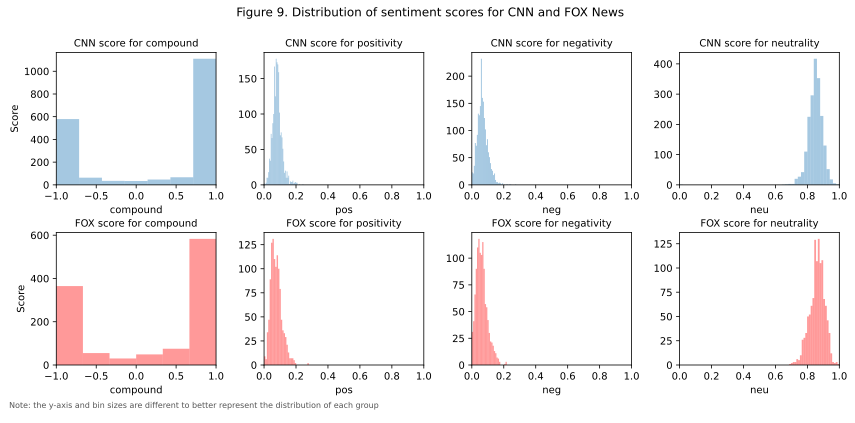

In [50]:
plot_sentiment_dist(cnn_df, fox_df)

The upper blue and lower red histograms depict CNN and FOX scores, respectively. The colors for the outlets were chosen to depict a proxy for mass media partisanship and are not reflective of their brand style design.

The compound scores have a bimodal distribution; positivity and negativity have positive skews, whereas neutrality seems to be rather normality distributed. Most articles have a rather high score for neutrality and low scores for positivity and negativity. For the purposes of this analysis, the compound score is mostly used. Although the t-test showed a significant result, the histograms suggest that the effect sizes are small.

The aggregated media sentiment has been changing throughout the pandemic. Th Figure 10 illustrates the daily change in sentiment together with daily change of COVID-19 cases.

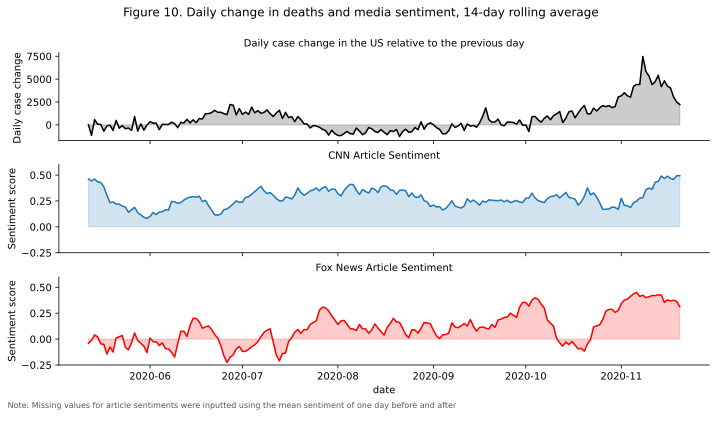

In [51]:
plot_article_sentiment_and_cases(df_plot)

The first graph depicts a rolling average of the daily case changes in the US relative to the previous day. The second and third graphs are CNN and FOX article sentiments, 14-day rolling average, over time. CNN articles seem to be more positive throughout the whole period with fewer fluctuations, something that has been suggested by the t-test.

However, absolute sentiment alone is not necessarily reflective of the relationship between COVID-19 cases, deaths, and media sentiment; analyzing the covariance of the variables might be useful. Table 1 showcases the Pearson's correlation coefficient for CNN and Fox News, daily death growth, and daily case growth.

In [52]:
display_covid_cases()

Table 1. Relationship between CNN and Fox News sentiment and COVID-19 cases and deaths


CNN R^2  CNN p-value   FOX R^2  FOX p-value
dead_growth   0.147668     0.044284 -0.100570     0.171998
cases_growth  0.200139     0.006164  0.179379     0.014293

The data suggests that CNN positive sentiment increases as the number of COVID-19 cases increase at p<0.01; the same is true for Fox News at p < 0.05. Although there could be theoretical mechanisms to justify this, I address the plausible reasons for this relationship in the limitations section. An additional way to for the relationship (especially for CNN given the small p-value) is by using Granger causality. If there is any theoretical link between positive sentiment and increase in COVID-19 cases, the relationship should hold only if the sentiment follows the deaths, and not vice versa. A Granger causality test can indicate whether this hypothesis is true. 

In [61]:
grangers_causality_matrix(granger_df, variables, display_table=False)

CNN sentiment is G-Causing the number of new cases at p = 0.1105
New cases are G-Causing CNN sentiment at p = 0.0016


the Granger causality test results indicate that Covid-19 cases G-cause CNN sentiment at p=0.0016. This can be interpreted by the positive sentiment of CNN articles increasing after COVID-19 cases increase. However, note that the stationarity assumption of the Granger causality was not met, and the linearity assumption should be further validated. A more robust approach is necessary to confirm this claim.

Furthermore, in the introduction, it was hypothesized that the articles that mention the president, defined as having the words *'Trump'* or *'president'* mentioned in the text, were more positive for FOX and negative for CNN. A comparison is made between the articles that mention the president within CNN and FOX News, respectively. The table with the sentiments is presented below.

In [53]:
calculate_p_values_outlets(df_pres, df_nopres, within=True, verbose=False, bonferroni=True, alpha=0.05, to_display=True)

Table 2. Sentiment differences between articles that mention the president and others


fox_sentiment_pres  fox_sentiment_nopres  p_value_pres  \
pos                  0.07937               0.07470       0.02786   
neg                  0.06606               0.05988       0.00324   
compound             0.17530               0.20249       0.58846   

          cnn_sentiment_pres  cnn_sentiment_nopres  p_value_no_pres  \
pos                  0.08208               0.08274          0.63412   
neg                  0.06780               0.06848          0.66049   
compound             0.26848               0.27452          0.88184   

         significant_pres significant_no_pres  
pos                 False               False  
neg                  True               False  
compound            False               False

Differences in positive, negative, and compound scores was measured for articles that mention the president and those that do not. The column outlet_sentiment_pres and outlet_sentiment_nopres show the sentiment for articles that do and do not mention the president for each sentiment group; the column p_value_pres and p_value_nopres show the p-value for the difference in the two sentiment values; significant_pres and significant_no_pres labels whether they are significant.

Given the large number of t-tests conducted, any relationship might have occurred simply by chance, thus a Bonferroni correction is applied. The only significant relationship after applying the correction is that of FOX News negative sentiment. Fox News tends to be significantly less negative in articles that do not mention the president. No relationship is observed for CNN with the given parameters. Thus, I rejected my second and third hypothesis that Fox News tends to be more positive and CNN more negative in articles that mention the president.

Moreover, to understand whether there is any visual difference between sentiments and COVID-19 articles, I build a network of articles, where each node is an article and each edge showcases that the article is similar in content and sentiment.

In [54]:
draw_cnn_fox_network(G)

Blue and red nodes represent CNN and FOX articles, respectively. A Kamada Kawai layout is used to position the nodes in the network. The whole graph seems to be dominated by CNN articles, while the majority of articles are clustered in the red-blue circle that overlap each other. Figure 12 depicts the sentiment distribution of these articles.

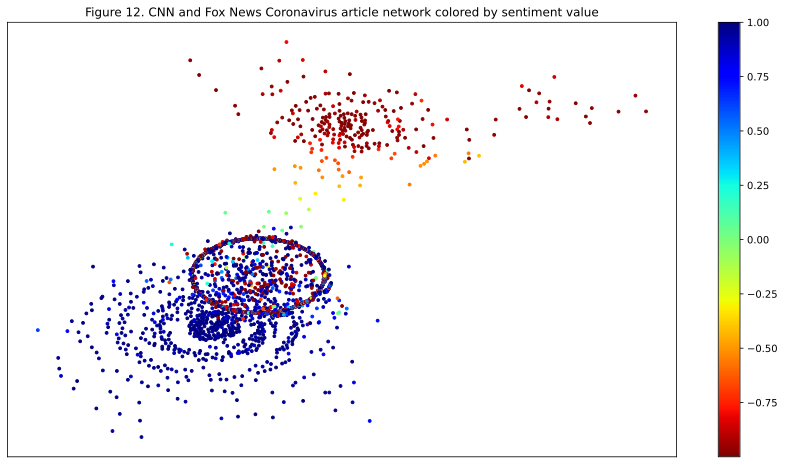

In [55]:
draw_cnn_fox_sentiment_network(G)

The color scheme represents the *compound* score provided by the VADER sentiment analyzer. The network represents two different clusters of sentiments. The nodes located at the top have a negative score and the nodes at the bottom left are more positive. So far, this graph tells us that there are two clusters of CNN articles, one with positive, and one with negative sentiments, and there is no visual relationship between outlet and sentiment in the circle that has overlapping FOX and CNN articles. There appears to be no visual difference in the sentiments of the two media outlets. Figure 13 zooms into the largest connected component that also contains the two CNN clusters.

In [56]:
get_largest_comp_graph(G)

A Fruchterman-Reingold force-directed algorithm was used to position the nodes. The color represents the media channel, and the size of the node is the degree centrality of each node. Note that the red nodes do not have high degree centrality scores, showcasing that, in this graph, few Fox News articles are related in content and sentiment. CNN articles tend to be more closely related in sentiment and content.

One of the main reasons why the node layout looks like this, however, is that the largest CNN cluster forms a clique of 118 nodes that are daily summary coronavirus articles. These CNN summary articles do not produce new content but are summaries of a couple of days, artificially creating nodes that are similar in content and sentiment and making it harder to see any relationships. For future analysis, removing such nodes could be considered.

# Limitations

## Limitations Part 1

The study on rural areas has several important limitations. First, a whole host of important explanatory variables are not taken into account. For instance, Nguimkeua and Tadadjeub (2020) have found that geographic and demographic characteristics impact COVID-19 spread in Africa that are not considered in my essay. Second, the study does not control for country-level urban-rural divisions. It would be more accurate to look at the COVID-19 spread within a given country in the rural and urban populations which might give substantially different results (and could even result in the Simpson's paradox). This would also resolve the issue of rural areas being proxies for the economic development of a country. Third, rural areas are not defined homogeneously by different countries, making it hard to know the true distribution of rural areas. Fourth, there were data reliability issues with the OXCOVID-19 database, such as declining cumulative numbers. 

## Limitations Part 2
There are significant limitations to the analysis and, hence, to the conclusions reached.
- First, only articles containing the word *coronavirus* in the title were scraped, making it arduous to generalize to the real population of articles about the pandemic. Other words, such as *pandemic* or *covid-19* could reveal different patterns and could be employed in the future. 
- Second, only articles that had *coronavirus* in the title were used due to the Fox News search API that limits the scope of the study. 
- Third, the sentiment scores can be misleading proxies for the real sentiment, especially given the COVID-19 context. For instance, on October 11th, Trump said "I tested totally negative!" which has a VADER score of -0.64, although it does not imply anything negative. This limitation substantially challenges the validity of the conclusions reached.
- Fourth, the network analysis revealed a plethora of connected CNN nodes that turned out to be daily briefings with a substantially different word and sentiment distribution from the other articles. This is because those articles re-stated other articles and did not report any new content. Although substantial preprocessing went into this analysis, more could be done to showcase the visual relationship between CNN and Fox News in the form of a network by removing such articles.
- Fifth, the TF-IDF score is a rudimentary bag-of-words model that disregard the context, sequence or grammar of text which makes it less reliable for claiming that two articles are similar in their content.
- Furthermore, it would be helpful to control for the topics that are being covered and analyze whether the different sentiments exists for the same topics. Latent Dirichlet allocation could be used to extract and control such topics in future research.
- Lastly, comparing more media outlets than just CNN and Fox News can help measure whether any differences found are at least partially a result of the outlets' partisanship roots, as argued in this paper, and not as a consequence of other confounding factors.

# References

Ash, E., Galletta, S., Hangartner, D., Margalit, Y., & Pinna, M. (2020). The Effect of Fox News on Health Behavior During COVID-19. *SSRN Electronic Journal*, 1–55. https://doi.org/10.2139/ssrn.3636762

Badr, H. S., Du, H., Marshall, M., Dong, E., Squire, M. M., & Gardner, L. M. (2020). Association between mobility patterns and COVID-19 transmission in the USA: a mathematical modelling study. *The Lancet Infectious Diseases, 20*(11), 1247–1254. https://doi.org/10.1016/S1473-3099(20)30553-3

Chaudhuri, S., & Roy, M. (2017). Rural-urban spatial inequality in water and sanitation facilities in India: A cross-sectional study from household to national level. *Applied Geography, 85*, 27–38. https://doi.org/10.1016/j.apgeog.2017.05.003

DEFRA. (2018). *Statistical Digest of Rural England*. www.nationalarchives.gov.uk/doc/open-government-licence/version/3/oremailPSI@nationalarchives.gsi.gov.ukwww.gov.uk/defra

Graber, D., & Dunaway, J. (2017). *Mass Media and American Politics*  (10th ed.). 	Thousand Oaks, California : CQ Press, An imprint of SAGE Publications, Inc. https://us.sagepub.com/en-us/nam/mass-media-and-american-politics/book248903

Hutto, C. J., & Gilbert, E. (2014). VADER: A parsimonious rule-based model for sentiment analysis of social media text. *Proceedings of the 8th International Conference on Weblogs and Social Media*, ICWSM 2014.

Jurkowitz, M., Mitchell, A., Shrearer, E., & Walker, M. (2020). *U.S. Media Polarization and the 2020 Election: A Nation Divided | Pew Research Center*. https://www.journalism.org/2020/01/24/u-s-media-polarization-and-the-2020-election-a-nation-divided/

Martin, G. J., & Yurukoglu, A. (2017). Bias in cable news: Persuasion and polarization. *American Economic Review*. https://doi.org/10.1257/aer.20160812

Nguimkeu, P., & Tadadjeu, S. (2020). Why is the number of COVID-19 cases lower than expected in Sub-Saharan Africa? A cross-sectional analysis of the role of demographic and geographic factors. *World Development*. https://doi.org/10.1016/j.worlddev.2020.105251

NRCN. (2015). *The True Cost of Crime in Rural Areas*. https://www.nationalruralcrimenetwork.net/content/uploads/2015/09/NRCN-National-Rural-Crime-Sur...pdf

OECD. (2015). *Health at a Glance 2015: OECD Indicators*. http://dx.doi.org/10.1787/health_glance-2015-en

Palmer, B., Appleby, J., & Spencer, J. (2019). *Rural health care A rapid review of the impact of rurality on the costs of delivering health care*. https://www.nuffieldtrust.org.uk/files/2019-01/rural-health-care-report-web3.pdf

Pew Research Center. (2019). *Digital gap between rural and nonrural America persists | Pew Research Center*. https://www.pewresearch.org/fact-tank/2019/05/31/digital-gap-between-rural-and-nonrural-america-persists/

Salim, A. (2013). ScienceDirect Management Information in Rural Area: A Case Study of Rancasalak Village in Garut, Indonesia. *The 4th International Conference on Electrical Engineering and Informatics (ICEEI 2013), 11*, 243–249. https://doi.org/10.1016/j.protcy.2013.12.187

Simonov, A., Sacher, S. K., Dubé, J.-P. H., Biswas, S., Petrova, M., Prat, A., Rao, A., Toubia, O., Ursu, R., & Yurukoglu, A. (2020). *The Persuasive Effect of Fox News: Non-Compliance with Social Distancing During the Covid-19 Pandemic*. http://www.nber.org/papers/w27237

Spasojevic, N., Vasilj, I., Hrabac, B., & Celik, D. (2015). Rural - Urban Differences in Health Care Quality Assessment. *Materia Socio Medica*, 27(6), 409. https://doi.org/10.5455/msm.2015.27.409-411

WHO. (2020). *Water, Sanitation, Hygiene, and Waste Management for SARS-CoV-2, the Virus that Causes COVID-19.* https://www.who.int/publications/i/item/WHO-2019-nCoV-IPC-WASH-2020.4

World Bank. (2020, October 26). *Rural population | Data Catalog*. https://datacatalog.worldbank.org/rural-population
